# Fitting a line to data

The [_Getting started_ tutorial](./getting-started.ipynb) shows how to sample a 3D gaussian with `simple`.
In this tutorial, we will build on this to demonstrate a more realistic scenario where we fit a line to data.

## Simulated data

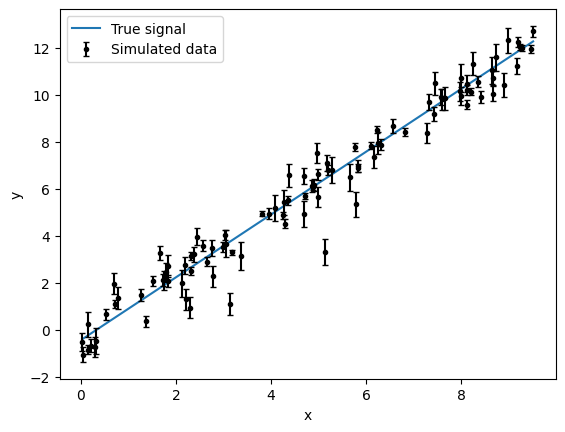

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import loguniform

rng = np.random.default_rng(123)

x = np.sort(10 * rng.random(100))
m_true = 1.338
b_true = -0.45
truths = {"m": m_true, "b": b_true, "sigma": None}
y_true = m_true * x + b_true
yerr = 0.1 + 0.5 * rng.random(x.size)
y = y_true + 2 * yerr * rng.normal(size=x.size)

ax = plt.gca()
ax.plot(x, y_true, label="True signal")
ax.errorbar(x, y, yerr=yerr, fmt="k.", capsize=2, label="Simulated data")
ax.set_ylabel("y")
ax.set_xlabel("x")
plt.legend()
plt.show()

## Linear model

In the [_Getting started_](./getting-started.ipynb) tutorial, we did not have a forward model: the likelihood was directly specified as a distribution.
In most physical scenarios, we have some sort of forward model, which is then called by our likelihood.
It is also quite common that the data points are assumed to be independent, and that the likelihood is assumed to be Gaussian.
`simple` covers the forward model, and the forward model + independent Gaussian likelihood cases with the `ForwardModel` and `GaussianForwardModel` classes.
See the [tutorial on types of models](./types_of_model.ipynb) for more on this.
Here, we will use the `GaussianForwardModel` as this is simpler in practice.
Since the likelihood is already implemented by `simple`, we only need to specify our forward model.

The forward model function should accept a dictionary of parameters.

In [2]:
def forward_model(parameters, x):
    m, b = parameters["m"], parameters["b"]
    return m * x + b

We can then pass this forward model to `simple.GaussianForwardModel`.
The gaussian forward model expects a `sigma` argument, which will be added in quadrature to the error bars.

In [3]:
from scipy.stats import uniform

from simple.distributions import ScipyDistribution
from simple.model import GaussianForwardModel

parameters = {
    "m": ScipyDistribution(uniform(-10, 20)),
    "b": ScipyDistribution(uniform(-10, 20)),
    "sigma": ScipyDistribution(loguniform(1e-5, 100)),
}

model = GaussianForwardModel(parameters, forward_model)

And we can check that the model works as expected.

In [4]:
test_point = {"m": 1.0, "b": 0, "sigma": 1.0}
print("Log prior", model.log_prior(test_point))
print("Log likelihood", model.log_likelihood(test_point, x, y, yerr))
print("Log probability", model.log_prob(test_point, x, y, yerr))

Log prior -8.77140714141125
Log likelihood -278.1711595345282
Log probability -286.9425666759395


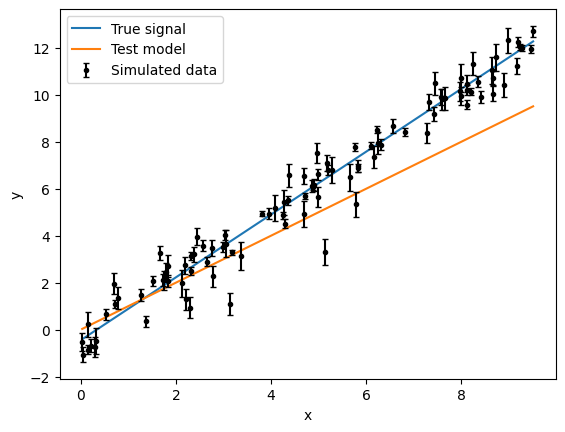

In [5]:
ax = plt.gca()
ax.plot(x, y_true, label="True signal")
ax.plot(x, model.forward(test_point, x), label="Test model")
ax.errorbar(x, y, yerr=yerr, fmt="k.", capsize=2, label="Simulated data")
ax.set_ylabel("y")
ax.set_xlabel("x")
plt.legend()
plt.show()

## Prior checks

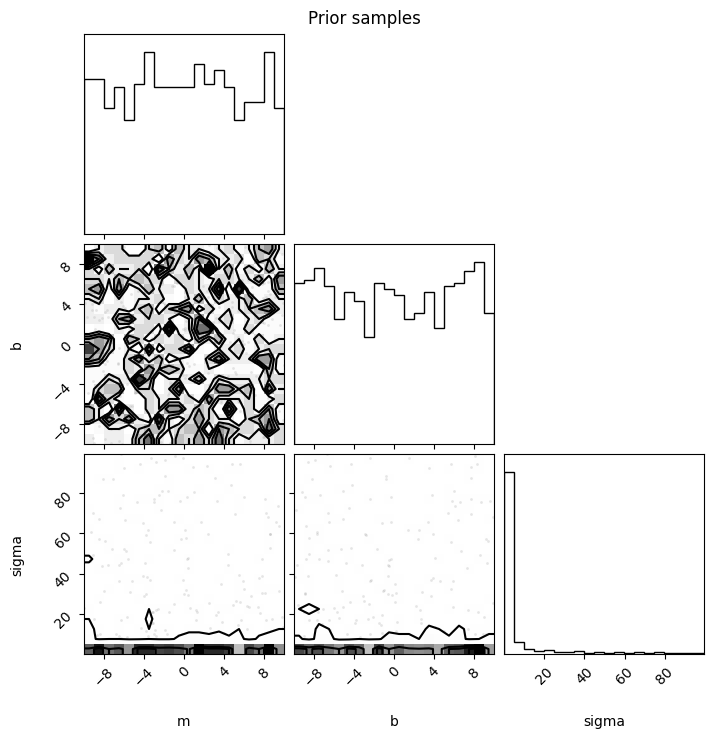

In [6]:
import corner

n_prior = 1000
prior_samples = model.get_prior_samples(n_prior)

fig = corner.corner(prior_samples)
fig.suptitle("Prior samples")
plt.show()

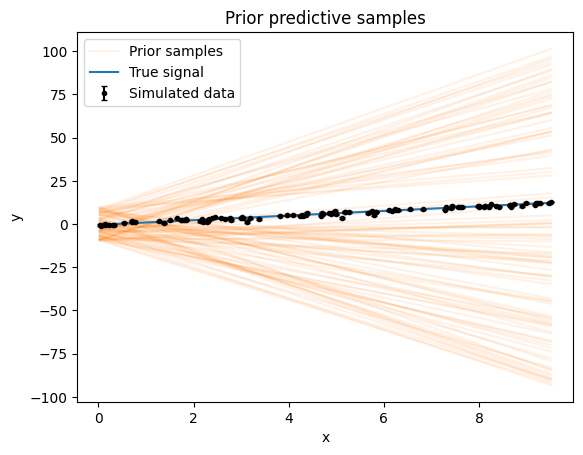

In [7]:
n_pred = 100
ypreds = model.get_prior_pred(n_pred, x)
ax = plt.gca()
for i, ypred in enumerate(ypreds):
    ax.plot(x, ypred, "C1-", label="Prior samples" if i == 0 else None, alpha=0.1)
ax.plot(x, y_true, label="True signal")
ax.errorbar(x, y, yerr=yerr, fmt="k.", capsize=2, label="Simulated data")
ax.set_ylabel("y")
ax.set_xlabel("x")
ax.set_title("Prior predictive samples")
plt.legend()
plt.show()

## Sampling

In [8]:
import zeus

nwalkers = 100
nsteps = 1000
ndim = len(model.keys())
start = np.array([0.0, 0.0, 10.0]) + rng.standard_normal(size=(nwalkers, ndim))
sampler = zeus.EnsembleSampler(nwalkers, ndim, model.log_prob, args=(x, y, yerr))
sampler.run_mcmc(start, nsteps)

Initialising ensemble of 100 walkers...


Sampling progress :   0%|                                                                                                                                                                                                                                                                          | 0/1000 [00:00<?, ?it/s]

Sampling progress :   0%|▌                                                                                                                                                                                                                                                                 | 2/1000 [00:00<01:30, 10.97it/s]

Sampling progress :   0%|█                                                                                                                                                                                                                                                                 | 4/1000 [00:00<01:34, 10.58it/s]

Sampling progress :   1%|█▌                                                                                                                                                                                                                                                                | 6/1000 [00:00<01:37, 10.24it/s]

Sampling progress :   1%|██                                                                                                                                                                                                                                                                | 8/1000 [00:00<01:37, 10.15it/s]

Sampling progress :   1%|██▌                                                                                                                                                                                                                                                              | 10/1000 [00:00<01:39,  9.96it/s]

Sampling progress :   1%|███                                                                                                                                                                                                                                                              | 12/1000 [00:01<01:38, 10.02it/s]

Sampling progress :   1%|███▌                                                                                                                                                                                                                                                             | 14/1000 [00:01<01:42,  9.66it/s]

Sampling progress :   2%|███▊                                                                                                                                                                                                                                                             | 15/1000 [00:01<01:44,  9.47it/s]

Sampling progress :   2%|████                                                                                                                                                                                                                                                             | 16/1000 [00:01<01:44,  9.37it/s]

Sampling progress :   2%|████▎                                                                                                                                                                                                                                                            | 17/1000 [00:01<01:47,  9.18it/s]

Sampling progress :   2%|████▋                                                                                                                                                                                                                                                            | 18/1000 [00:01<01:50,  8.92it/s]

Sampling progress :   2%|████▉                                                                                                                                                                                                                                                            | 19/1000 [00:01<01:51,  8.82it/s]

Sampling progress :   2%|█████▏                                                                                                                                                                                                                                                           | 20/1000 [00:02<01:52,  8.74it/s]

Sampling progress :   2%|█████▍                                                                                                                                                                                                                                                           | 21/1000 [00:02<01:51,  8.77it/s]

Sampling progress :   2%|█████▋                                                                                                                                                                                                                                                           | 22/1000 [00:02<01:50,  8.83it/s]

Sampling progress :   2%|█████▉                                                                                                                                                                                                                                                           | 23/1000 [00:02<01:52,  8.67it/s]

Sampling progress :   2%|██████▏                                                                                                                                                                                                                                                          | 24/1000 [00:02<01:55,  8.46it/s]

Sampling progress :   2%|██████▍                                                                                                                                                                                                                                                          | 25/1000 [00:02<01:58,  8.26it/s]

Sampling progress :   3%|██████▋                                                                                                                                                                                                                                                          | 26/1000 [00:02<02:02,  7.94it/s]

Sampling progress :   3%|██████▉                                                                                                                                                                                                                                                          | 27/1000 [00:02<02:01,  7.99it/s]

Sampling progress :   3%|███████▏                                                                                                                                                                                                                                                         | 28/1000 [00:03<01:59,  8.16it/s]

Sampling progress :   3%|███████▍                                                                                                                                                                                                                                                         | 29/1000 [00:03<02:00,  8.03it/s]

Sampling progress :   3%|███████▋                                                                                                                                                                                                                                                         | 30/1000 [00:03<02:02,  7.91it/s]

Sampling progress :   3%|███████▉                                                                                                                                                                                                                                                         | 31/1000 [00:03<02:03,  7.86it/s]

Sampling progress :   3%|████████▏                                                                                                                                                                                                                                                        | 32/1000 [00:03<02:05,  7.69it/s]

Sampling progress :   3%|████████▍                                                                                                                                                                                                                                                        | 33/1000 [00:03<02:07,  7.58it/s]

Sampling progress :   3%|████████▋                                                                                                                                                                                                                                                        | 34/1000 [00:03<02:07,  7.60it/s]

Sampling progress :   4%|████████▉                                                                                                                                                                                                                                                        | 35/1000 [00:04<02:13,  7.23it/s]

Sampling progress :   4%|█████████▎                                                                                                                                                                                                                                                       | 36/1000 [00:04<02:10,  7.37it/s]

Sampling progress :   4%|█████████▌                                                                                                                                                                                                                                                       | 37/1000 [00:04<02:07,  7.54it/s]

Sampling progress :   4%|█████████▊                                                                                                                                                                                                                                                       | 38/1000 [00:04<02:08,  7.50it/s]

Sampling progress :   4%|██████████                                                                                                                                                                                                                                                       | 39/1000 [00:04<02:07,  7.55it/s]

Sampling progress :   4%|██████████▎                                                                                                                                                                                                                                                      | 40/1000 [00:04<02:08,  7.49it/s]

Sampling progress :   4%|██████████▌                                                                                                                                                                                                                                                      | 41/1000 [00:04<02:08,  7.49it/s]

Sampling progress :   4%|██████████▊                                                                                                                                                                                                                                                      | 42/1000 [00:04<02:14,  7.14it/s]

Sampling progress :   4%|███████████                                                                                                                                                                                                                                                      | 43/1000 [00:05<02:17,  6.94it/s]

Sampling progress :   4%|███████████▎                                                                                                                                                                                                                                                     | 44/1000 [00:05<02:17,  6.98it/s]

Sampling progress :   4%|███████████▌                                                                                                                                                                                                                                                     | 45/1000 [00:05<02:17,  6.94it/s]

Sampling progress :   5%|███████████▊                                                                                                                                                                                                                                                     | 46/1000 [00:05<02:14,  7.09it/s]

Sampling progress :   5%|████████████                                                                                                                                                                                                                                                     | 47/1000 [00:05<02:12,  7.20it/s]

Sampling progress :   5%|████████████▎                                                                                                                                                                                                                                                    | 48/1000 [00:05<02:15,  7.03it/s]

Sampling progress :   5%|████████████▌                                                                                                                                                                                                                                                    | 49/1000 [00:05<02:21,  6.72it/s]

Sampling progress :   5%|████████████▊                                                                                                                                                                                                                                                    | 50/1000 [00:06<02:20,  6.78it/s]

Sampling progress :   5%|█████████████                                                                                                                                                                                                                                                    | 51/1000 [00:06<02:19,  6.81it/s]

Sampling progress :   5%|█████████████▎                                                                                                                                                                                                                                                   | 52/1000 [00:06<02:13,  7.12it/s]

Sampling progress :   5%|█████████████▌                                                                                                                                                                                                                                                   | 53/1000 [00:06<02:11,  7.22it/s]

Sampling progress :   5%|█████████████▉                                                                                                                                                                                                                                                   | 54/1000 [00:06<02:10,  7.25it/s]

Sampling progress :   6%|██████████████▏                                                                                                                                                                                                                                                  | 55/1000 [00:06<02:23,  6.56it/s]

Sampling progress :   6%|██████████████▍                                                                                                                                                                                                                                                  | 56/1000 [00:07<02:21,  6.65it/s]

Sampling progress :   6%|██████████████▋                                                                                                                                                                                                                                                  | 57/1000 [00:07<02:22,  6.60it/s]

Sampling progress :   6%|██████████████▉                                                                                                                                                                                                                                                  | 58/1000 [00:07<02:25,  6.46it/s]

Sampling progress :   6%|███████████████▏                                                                                                                                                                                                                                                 | 59/1000 [00:07<02:24,  6.50it/s]

Sampling progress :   6%|███████████████▍                                                                                                                                                                                                                                                 | 60/1000 [00:07<02:23,  6.56it/s]

Sampling progress :   6%|███████████████▋                                                                                                                                                                                                                                                 | 61/1000 [00:07<02:22,  6.57it/s]

Sampling progress :   6%|███████████████▉                                                                                                                                                                                                                                                 | 62/1000 [00:07<02:24,  6.50it/s]

Sampling progress :   6%|████████████████▏                                                                                                                                                                                                                                                | 63/1000 [00:08<02:25,  6.45it/s]

Sampling progress :   6%|████████████████▍                                                                                                                                                                                                                                                | 64/1000 [00:08<02:23,  6.51it/s]

Sampling progress :   6%|████████████████▋                                                                                                                                                                                                                                                | 65/1000 [00:08<02:28,  6.28it/s]

Sampling progress :   7%|████████████████▉                                                                                                                                                                                                                                                | 66/1000 [00:08<02:27,  6.32it/s]

Sampling progress :   7%|█████████████████▏                                                                                                                                                                                                                                               | 67/1000 [00:08<02:35,  6.01it/s]

Sampling progress :   7%|█████████████████▍                                                                                                                                                                                                                                               | 68/1000 [00:08<02:32,  6.12it/s]

Sampling progress :   7%|█████████████████▋                                                                                                                                                                                                                                               | 69/1000 [00:09<02:37,  5.92it/s]

Sampling progress :   7%|█████████████████▉                                                                                                                                                                                                                                               | 70/1000 [00:09<02:38,  5.88it/s]

Sampling progress :   7%|██████████████████▏                                                                                                                                                                                                                                              | 71/1000 [00:09<02:38,  5.87it/s]

Sampling progress :   7%|██████████████████▌                                                                                                                                                                                                                                              | 72/1000 [00:09<02:33,  6.06it/s]

Sampling progress :   7%|██████████████████▊                                                                                                                                                                                                                                              | 73/1000 [00:09<02:36,  5.91it/s]

Sampling progress :   7%|███████████████████                                                                                                                                                                                                                                              | 74/1000 [00:09<02:41,  5.73it/s]

Sampling progress :   8%|███████████████████▎                                                                                                                                                                                                                                             | 75/1000 [00:10<02:38,  5.83it/s]

Sampling progress :   8%|███████████████████▌                                                                                                                                                                                                                                             | 76/1000 [00:10<02:37,  5.86it/s]

Sampling progress :   8%|███████████████████▊                                                                                                                                                                                                                                             | 77/1000 [00:10<02:46,  5.53it/s]

Sampling progress :   8%|████████████████████                                                                                                                                                                                                                                             | 78/1000 [00:10<02:44,  5.61it/s]

Sampling progress :   8%|████████████████████▎                                                                                                                                                                                                                                            | 79/1000 [00:10<02:39,  5.77it/s]

Sampling progress :   8%|████████████████████▌                                                                                                                                                                                                                                            | 80/1000 [00:10<02:31,  6.06it/s]

Sampling progress :   8%|████████████████████▊                                                                                                                                                                                                                                            | 81/1000 [00:11<02:28,  6.17it/s]

Sampling progress :   8%|█████████████████████                                                                                                                                                                                                                                            | 82/1000 [00:11<02:27,  6.21it/s]

Sampling progress :   8%|█████████████████████▎                                                                                                                                                                                                                                           | 83/1000 [00:11<02:25,  6.30it/s]

Sampling progress :   8%|█████████████████████▌                                                                                                                                                                                                                                           | 84/1000 [00:11<02:26,  6.24it/s]

Sampling progress :   8%|█████████████████████▊                                                                                                                                                                                                                                           | 85/1000 [00:11<02:26,  6.23it/s]

Sampling progress :   9%|██████████████████████                                                                                                                                                                                                                                           | 86/1000 [00:11<02:46,  5.50it/s]

Sampling progress :   9%|██████████████████████▎                                                                                                                                                                                                                                          | 87/1000 [00:12<02:51,  5.33it/s]

Sampling progress :   9%|██████████████████████▌                                                                                                                                                                                                                                          | 88/1000 [00:12<02:51,  5.31it/s]

Sampling progress :   9%|██████████████████████▊                                                                                                                                                                                                                                          | 89/1000 [00:12<02:45,  5.49it/s]

Sampling progress :   9%|███████████████████████▏                                                                                                                                                                                                                                         | 90/1000 [00:12<02:53,  5.25it/s]

Sampling progress :   9%|███████████████████████▍                                                                                                                                                                                                                                         | 91/1000 [00:12<02:47,  5.42it/s]

Sampling progress :   9%|███████████████████████▋                                                                                                                                                                                                                                         | 92/1000 [00:13<02:41,  5.62it/s]

Sampling progress :   9%|███████████████████████▉                                                                                                                                                                                                                                         | 93/1000 [00:13<02:42,  5.58it/s]

Sampling progress :   9%|████████████████████████▏                                                                                                                                                                                                                                        | 94/1000 [00:13<02:33,  5.91it/s]

Sampling progress :  10%|████████████████████████▍                                                                                                                                                                                                                                        | 95/1000 [00:13<02:36,  5.79it/s]

Sampling progress :  10%|████████████████████████▋                                                                                                                                                                                                                                        | 96/1000 [00:13<02:34,  5.85it/s]

Sampling progress :  10%|████████████████████████▉                                                                                                                                                                                                                                        | 97/1000 [00:13<02:34,  5.86it/s]

Sampling progress :  10%|█████████████████████████▏                                                                                                                                                                                                                                       | 98/1000 [00:14<02:35,  5.80it/s]

Sampling progress :  10%|█████████████████████████▍                                                                                                                                                                                                                                       | 99/1000 [00:14<02:35,  5.78it/s]

Sampling progress :  10%|█████████████████████████▌                                                                                                                                                                                                                                      | 100/1000 [00:14<02:35,  5.77it/s]

Sampling progress :  10%|█████████████████████████▊                                                                                                                                                                                                                                      | 101/1000 [00:14<02:31,  5.92it/s]

Sampling progress :  10%|██████████████████████████                                                                                                                                                                                                                                      | 102/1000 [00:14<02:25,  6.15it/s]

Sampling progress :  10%|██████████████████████████▎                                                                                                                                                                                                                                     | 103/1000 [00:14<02:23,  6.27it/s]

Sampling progress :  10%|██████████████████████████▌                                                                                                                                                                                                                                     | 104/1000 [00:15<02:27,  6.08it/s]

Sampling progress :  10%|██████████████████████████▉                                                                                                                                                                                                                                     | 105/1000 [00:15<02:26,  6.10it/s]

Sampling progress :  11%|███████████████████████████▏                                                                                                                                                                                                                                    | 106/1000 [00:15<02:26,  6.12it/s]

Sampling progress :  11%|███████████████████████████▍                                                                                                                                                                                                                                    | 107/1000 [00:15<02:23,  6.22it/s]

Sampling progress :  11%|███████████████████████████▋                                                                                                                                                                                                                                    | 108/1000 [00:15<02:21,  6.30it/s]

Sampling progress :  11%|███████████████████████████▉                                                                                                                                                                                                                                    | 109/1000 [00:15<02:24,  6.18it/s]

Sampling progress :  11%|████████████████████████████▏                                                                                                                                                                                                                                   | 110/1000 [00:16<02:25,  6.13it/s]

Sampling progress :  11%|████████████████████████████▍                                                                                                                                                                                                                                   | 111/1000 [00:16<02:25,  6.13it/s]

Sampling progress :  11%|████████████████████████████▋                                                                                                                                                                                                                                   | 112/1000 [00:16<02:28,  6.00it/s]

Sampling progress :  11%|████████████████████████████▉                                                                                                                                                                                                                                   | 113/1000 [00:16<02:29,  5.93it/s]

Sampling progress :  11%|█████████████████████████████▏                                                                                                                                                                                                                                  | 114/1000 [00:16<02:26,  6.05it/s]

Sampling progress :  12%|█████████████████████████████▍                                                                                                                                                                                                                                  | 115/1000 [00:16<02:27,  5.99it/s]

Sampling progress :  12%|█████████████████████████████▋                                                                                                                                                                                                                                  | 116/1000 [00:17<02:28,  5.94it/s]

Sampling progress :  12%|█████████████████████████████▉                                                                                                                                                                                                                                  | 117/1000 [00:17<02:29,  5.90it/s]

Sampling progress :  12%|██████████████████████████████▏                                                                                                                                                                                                                                 | 118/1000 [00:17<02:25,  6.06it/s]

Sampling progress :  12%|██████████████████████████████▍                                                                                                                                                                                                                                 | 119/1000 [00:17<02:26,  6.02it/s]

Sampling progress :  12%|██████████████████████████████▋                                                                                                                                                                                                                                 | 120/1000 [00:17<02:27,  5.98it/s]

Sampling progress :  12%|██████████████████████████████▉                                                                                                                                                                                                                                 | 121/1000 [00:17<02:26,  6.00it/s]

Sampling progress :  12%|███████████████████████████████▏                                                                                                                                                                                                                                | 122/1000 [00:18<02:30,  5.83it/s]

Sampling progress :  12%|███████████████████████████████▍                                                                                                                                                                                                                                | 123/1000 [00:18<02:29,  5.88it/s]

Sampling progress :  12%|███████████████████████████████▋                                                                                                                                                                                                                                | 124/1000 [00:18<02:28,  5.90it/s]

Sampling progress :  12%|████████████████████████████████                                                                                                                                                                                                                                | 125/1000 [00:18<02:30,  5.81it/s]

Sampling progress :  13%|████████████████████████████████▎                                                                                                                                                                                                                               | 126/1000 [00:18<02:29,  5.86it/s]

Sampling progress :  13%|████████████████████████████████▌                                                                                                                                                                                                                               | 127/1000 [00:18<02:25,  6.02it/s]

Sampling progress :  13%|████████████████████████████████▊                                                                                                                                                                                                                               | 128/1000 [00:19<02:26,  5.95it/s]

Sampling progress :  13%|█████████████████████████████████                                                                                                                                                                                                                               | 129/1000 [00:19<02:23,  6.06it/s]

Sampling progress :  13%|█████████████████████████████████▎                                                                                                                                                                                                                              | 130/1000 [00:19<02:23,  6.07it/s]

Sampling progress :  13%|█████████████████████████████████▌                                                                                                                                                                                                                              | 131/1000 [00:19<02:23,  6.06it/s]

Sampling progress :  13%|█████████████████████████████████▊                                                                                                                                                                                                                              | 132/1000 [00:19<02:25,  5.97it/s]

Sampling progress :  13%|██████████████████████████████████                                                                                                                                                                                                                              | 133/1000 [00:19<02:27,  5.87it/s]

Sampling progress :  13%|██████████████████████████████████▎                                                                                                                                                                                                                             | 134/1000 [00:20<02:29,  5.80it/s]

Sampling progress :  14%|██████████████████████████████████▌                                                                                                                                                                                                                             | 135/1000 [00:20<02:28,  5.83it/s]

Sampling progress :  14%|██████████████████████████████████▊                                                                                                                                                                                                                             | 136/1000 [00:20<02:20,  6.16it/s]

Sampling progress :  14%|███████████████████████████████████                                                                                                                                                                                                                             | 137/1000 [00:20<02:21,  6.11it/s]

Sampling progress :  14%|███████████████████████████████████▎                                                                                                                                                                                                                            | 138/1000 [00:20<02:21,  6.07it/s]

Sampling progress :  14%|███████████████████████████████████▌                                                                                                                                                                                                                            | 139/1000 [00:20<02:27,  5.85it/s]

Sampling progress :  14%|███████████████████████████████████▊                                                                                                                                                                                                                            | 140/1000 [00:21<02:30,  5.70it/s]

Sampling progress :  14%|████████████████████████████████████                                                                                                                                                                                                                            | 141/1000 [00:21<02:26,  5.87it/s]

Sampling progress :  14%|████████████████████████████████████▎                                                                                                                                                                                                                           | 142/1000 [00:21<02:24,  5.92it/s]

Sampling progress :  14%|████████████████████████████████████▌                                                                                                                                                                                                                           | 143/1000 [00:21<02:21,  6.06it/s]

Sampling progress :  14%|████████████████████████████████████▊                                                                                                                                                                                                                           | 144/1000 [00:21<02:23,  5.96it/s]

Sampling progress :  14%|█████████████████████████████████████                                                                                                                                                                                                                           | 145/1000 [00:21<02:24,  5.92it/s]

Sampling progress :  15%|█████████████████████████████████████▍                                                                                                                                                                                                                          | 146/1000 [00:22<02:26,  5.84it/s]

Sampling progress :  15%|█████████████████████████████████████▋                                                                                                                                                                                                                          | 147/1000 [00:22<02:21,  6.03it/s]

Sampling progress :  15%|█████████████████████████████████████▉                                                                                                                                                                                                                          | 148/1000 [00:22<02:20,  6.05it/s]

Sampling progress :  15%|██████████████████████████████████████▏                                                                                                                                                                                                                         | 149/1000 [00:22<02:27,  5.77it/s]

Sampling progress :  15%|██████████████████████████████████████▍                                                                                                                                                                                                                         | 150/1000 [00:22<02:36,  5.42it/s]

Sampling progress :  15%|██████████████████████████████████████▋                                                                                                                                                                                                                         | 151/1000 [00:23<02:36,  5.42it/s]

Sampling progress :  15%|██████████████████████████████████████▉                                                                                                                                                                                                                         | 152/1000 [00:23<02:31,  5.60it/s]

Sampling progress :  15%|███████████████████████████████████████▏                                                                                                                                                                                                                        | 153/1000 [00:23<02:27,  5.73it/s]

Sampling progress :  15%|███████████████████████████████████████▍                                                                                                                                                                                                                        | 154/1000 [00:23<02:32,  5.54it/s]

Sampling progress :  16%|███████████████████████████████████████▋                                                                                                                                                                                                                        | 155/1000 [00:23<02:31,  5.58it/s]

Sampling progress :  16%|███████████████████████████████████████▉                                                                                                                                                                                                                        | 156/1000 [00:23<02:32,  5.52it/s]

Sampling progress :  16%|████████████████████████████████████████▏                                                                                                                                                                                                                       | 157/1000 [00:24<02:28,  5.66it/s]

Sampling progress :  16%|████████████████████████████████████████▍                                                                                                                                                                                                                       | 158/1000 [00:24<02:33,  5.49it/s]

Sampling progress :  16%|████████████████████████████████████████▋                                                                                                                                                                                                                       | 159/1000 [00:24<02:29,  5.61it/s]

Sampling progress :  16%|████████████████████████████████████████▉                                                                                                                                                                                                                       | 160/1000 [00:24<02:28,  5.65it/s]

Sampling progress :  16%|█████████████████████████████████████████▏                                                                                                                                                                                                                      | 161/1000 [00:24<02:25,  5.76it/s]

Sampling progress :  16%|█████████████████████████████████████████▍                                                                                                                                                                                                                      | 162/1000 [00:25<02:31,  5.52it/s]

Sampling progress :  16%|█████████████████████████████████████████▋                                                                                                                                                                                                                      | 163/1000 [00:25<02:27,  5.67it/s]

Sampling progress :  16%|█████████████████████████████████████████▉                                                                                                                                                                                                                      | 164/1000 [00:25<02:25,  5.74it/s]

Sampling progress :  16%|██████████████████████████████████████████▏                                                                                                                                                                                                                     | 165/1000 [00:25<02:20,  5.95it/s]

Sampling progress :  17%|██████████████████████████████████████████▍                                                                                                                                                                                                                     | 166/1000 [00:25<02:18,  6.02it/s]

Sampling progress :  17%|██████████████████████████████████████████▊                                                                                                                                                                                                                     | 167/1000 [00:25<02:17,  6.07it/s]

Sampling progress :  17%|███████████████████████████████████████████                                                                                                                                                                                                                     | 168/1000 [00:25<02:13,  6.21it/s]

Sampling progress :  17%|███████████████████████████████████████████▎                                                                                                                                                                                                                    | 169/1000 [00:26<02:13,  6.23it/s]

Sampling progress :  17%|███████████████████████████████████████████▌                                                                                                                                                                                                                    | 170/1000 [00:26<02:12,  6.25it/s]

Sampling progress :  17%|███████████████████████████████████████████▊                                                                                                                                                                                                                    | 171/1000 [00:26<02:10,  6.35it/s]

Sampling progress :  17%|████████████████████████████████████████████                                                                                                                                                                                                                    | 172/1000 [00:26<02:12,  6.27it/s]

Sampling progress :  17%|████████████████████████████████████████████▎                                                                                                                                                                                                                   | 173/1000 [00:26<02:15,  6.12it/s]

Sampling progress :  17%|████████████████████████████████████████████▌                                                                                                                                                                                                                   | 174/1000 [00:26<02:24,  5.71it/s]

Sampling progress :  18%|████████████████████████████████████████████▊                                                                                                                                                                                                                   | 175/1000 [00:27<02:26,  5.64it/s]

Sampling progress :  18%|█████████████████████████████████████████████                                                                                                                                                                                                                   | 176/1000 [00:27<02:25,  5.65it/s]

Sampling progress :  18%|█████████████████████████████████████████████▎                                                                                                                                                                                                                  | 177/1000 [00:27<02:21,  5.80it/s]

Sampling progress :  18%|█████████████████████████████████████████████▌                                                                                                                                                                                                                  | 178/1000 [00:27<02:29,  5.49it/s]

Sampling progress :  18%|█████████████████████████████████████████████▊                                                                                                                                                                                                                  | 179/1000 [00:27<02:25,  5.64it/s]

Sampling progress :  18%|██████████████████████████████████████████████                                                                                                                                                                                                                  | 180/1000 [00:28<02:24,  5.67it/s]

Sampling progress :  18%|██████████████████████████████████████████████▎                                                                                                                                                                                                                 | 181/1000 [00:28<02:23,  5.73it/s]

Sampling progress :  18%|██████████████████████████████████████████████▌                                                                                                                                                                                                                 | 182/1000 [00:28<02:26,  5.60it/s]

Sampling progress :  18%|██████████████████████████████████████████████▊                                                                                                                                                                                                                 | 183/1000 [00:28<02:32,  5.37it/s]

Sampling progress :  18%|███████████████████████████████████████████████                                                                                                                                                                                                                 | 184/1000 [00:28<02:33,  5.31it/s]

Sampling progress :  18%|███████████████████████████████████████████████▎                                                                                                                                                                                                                | 185/1000 [00:29<02:38,  5.14it/s]

Sampling progress :  19%|███████████████████████████████████████████████▌                                                                                                                                                                                                                | 186/1000 [00:29<02:48,  4.83it/s]

Sampling progress :  19%|███████████████████████████████████████████████▊                                                                                                                                                                                                                | 187/1000 [00:29<02:43,  4.98it/s]

Sampling progress :  19%|████████████████████████████████████████████████▏                                                                                                                                                                                                               | 188/1000 [00:29<02:37,  5.16it/s]

Sampling progress :  19%|████████████████████████████████████████████████▍                                                                                                                                                                                                               | 189/1000 [00:29<02:29,  5.41it/s]

Sampling progress :  19%|████████████████████████████████████████████████▋                                                                                                                                                                                                               | 190/1000 [00:29<02:24,  5.62it/s]

Sampling progress :  19%|████████████████████████████████████████████████▉                                                                                                                                                                                                               | 191/1000 [00:30<02:22,  5.67it/s]

Sampling progress :  19%|█████████████████████████████████████████████████▏                                                                                                                                                                                                              | 192/1000 [00:30<02:20,  5.76it/s]

Sampling progress :  19%|█████████████████████████████████████████████████▍                                                                                                                                                                                                              | 193/1000 [00:30<02:12,  6.11it/s]

Sampling progress :  19%|█████████████████████████████████████████████████▋                                                                                                                                                                                                              | 194/1000 [00:30<02:16,  5.91it/s]

Sampling progress :  20%|█████████████████████████████████████████████████▉                                                                                                                                                                                                              | 195/1000 [00:30<02:20,  5.73it/s]

Sampling progress :  20%|██████████████████████████████████████████████████▏                                                                                                                                                                                                             | 196/1000 [00:30<02:26,  5.50it/s]

Sampling progress :  20%|██████████████████████████████████████████████████▍                                                                                                                                                                                                             | 197/1000 [00:31<02:21,  5.69it/s]

Sampling progress :  20%|██████████████████████████████████████████████████▋                                                                                                                                                                                                             | 198/1000 [00:31<02:17,  5.84it/s]

Sampling progress :  20%|██████████████████████████████████████████████████▉                                                                                                                                                                                                             | 199/1000 [00:31<02:15,  5.91it/s]

Sampling progress :  20%|███████████████████████████████████████████████████▏                                                                                                                                                                                                            | 200/1000 [00:31<02:15,  5.91it/s]

Sampling progress :  20%|███████████████████████████████████████████████████▍                                                                                                                                                                                                            | 201/1000 [00:31<02:15,  5.88it/s]

Sampling progress :  20%|███████████████████████████████████████████████████▋                                                                                                                                                                                                            | 202/1000 [00:31<02:16,  5.85it/s]

Sampling progress :  20%|███████████████████████████████████████████████████▉                                                                                                                                                                                                            | 203/1000 [00:32<02:17,  5.81it/s]

Sampling progress :  20%|████████████████████████████████████████████████████▏                                                                                                                                                                                                           | 204/1000 [00:32<02:19,  5.72it/s]

Sampling progress :  20%|████████████████████████████████████████████████████▍                                                                                                                                                                                                           | 205/1000 [00:32<02:19,  5.72it/s]

Sampling progress :  21%|████████████████████████████████████████████████████▋                                                                                                                                                                                                           | 206/1000 [00:32<02:12,  6.01it/s]

Sampling progress :  21%|████████████████████████████████████████████████████▉                                                                                                                                                                                                           | 207/1000 [00:32<02:11,  6.05it/s]

Sampling progress :  21%|█████████████████████████████████████████████████████▏                                                                                                                                                                                                          | 208/1000 [00:32<02:11,  6.04it/s]

Sampling progress :  21%|█████████████████████████████████████████████████████▌                                                                                                                                                                                                          | 209/1000 [00:33<02:11,  6.03it/s]

Sampling progress :  21%|█████████████████████████████████████████████████████▊                                                                                                                                                                                                          | 210/1000 [00:33<02:10,  6.04it/s]

Sampling progress :  21%|██████████████████████████████████████████████████████                                                                                                                                                                                                          | 211/1000 [00:33<02:13,  5.91it/s]

Sampling progress :  21%|██████████████████████████████████████████████████████▎                                                                                                                                                                                                         | 212/1000 [00:33<02:15,  5.83it/s]

Sampling progress :  21%|██████████████████████████████████████████████████████▌                                                                                                                                                                                                         | 213/1000 [00:33<02:12,  5.95it/s]

Sampling progress :  21%|██████████████████████████████████████████████████████▊                                                                                                                                                                                                         | 214/1000 [00:33<02:08,  6.13it/s]

Sampling progress :  22%|███████████████████████████████████████████████████████                                                                                                                                                                                                         | 215/1000 [00:34<02:11,  5.97it/s]

Sampling progress :  22%|███████████████████████████████████████████████████████▎                                                                                                                                                                                                        | 216/1000 [00:34<02:13,  5.89it/s]

Sampling progress :  22%|███████████████████████████████████████████████████████▌                                                                                                                                                                                                        | 217/1000 [00:34<02:18,  5.67it/s]

Sampling progress :  22%|███████████████████████████████████████████████████████▊                                                                                                                                                                                                        | 218/1000 [00:34<02:20,  5.57it/s]

Sampling progress :  22%|████████████████████████████████████████████████████████                                                                                                                                                                                                        | 219/1000 [00:34<02:18,  5.64it/s]

Sampling progress :  22%|████████████████████████████████████████████████████████▎                                                                                                                                                                                                       | 220/1000 [00:35<02:16,  5.73it/s]

Sampling progress :  22%|████████████████████████████████████████████████████████▌                                                                                                                                                                                                       | 221/1000 [00:35<02:17,  5.69it/s]

Sampling progress :  22%|████████████████████████████████████████████████████████▊                                                                                                                                                                                                       | 222/1000 [00:35<02:18,  5.61it/s]

Sampling progress :  22%|█████████████████████████████████████████████████████████                                                                                                                                                                                                       | 223/1000 [00:35<02:17,  5.65it/s]

Sampling progress :  22%|█████████████████████████████████████████████████████████▎                                                                                                                                                                                                      | 224/1000 [00:35<02:18,  5.59it/s]

Sampling progress :  22%|█████████████████████████████████████████████████████████▌                                                                                                                                                                                                      | 225/1000 [00:35<02:11,  5.91it/s]

Sampling progress :  23%|█████████████████████████████████████████████████████████▊                                                                                                                                                                                                      | 226/1000 [00:36<02:14,  5.76it/s]

Sampling progress :  23%|██████████████████████████████████████████████████████████                                                                                                                                                                                                      | 227/1000 [00:36<02:19,  5.55it/s]

Sampling progress :  23%|██████████████████████████████████████████████████████████▎                                                                                                                                                                                                     | 228/1000 [00:36<02:20,  5.50it/s]

Sampling progress :  23%|██████████████████████████████████████████████████████████▌                                                                                                                                                                                                     | 229/1000 [00:36<02:19,  5.53it/s]

Sampling progress :  23%|██████████████████████████████████████████████████████████▉                                                                                                                                                                                                     | 230/1000 [00:36<02:21,  5.45it/s]

Sampling progress :  23%|███████████████████████████████████████████████████████████▏                                                                                                                                                                                                    | 231/1000 [00:37<02:19,  5.51it/s]

Sampling progress :  23%|███████████████████████████████████████████████████████████▍                                                                                                                                                                                                    | 232/1000 [00:37<02:20,  5.48it/s]

Sampling progress :  23%|███████████████████████████████████████████████████████████▋                                                                                                                                                                                                    | 233/1000 [00:37<02:30,  5.11it/s]

Sampling progress :  23%|███████████████████████████████████████████████████████████▉                                                                                                                                                                                                    | 234/1000 [00:37<02:26,  5.23it/s]

Sampling progress :  24%|████████████████████████████████████████████████████████████▏                                                                                                                                                                                                   | 235/1000 [00:37<02:19,  5.49it/s]

Sampling progress :  24%|████████████████████████████████████████████████████████████▍                                                                                                                                                                                                   | 236/1000 [00:37<02:14,  5.68it/s]

Sampling progress :  24%|████████████████████████████████████████████████████████████▋                                                                                                                                                                                                   | 237/1000 [00:38<02:13,  5.73it/s]

Sampling progress :  24%|████████████████████████████████████████████████████████████▉                                                                                                                                                                                                   | 238/1000 [00:38<02:12,  5.75it/s]

Sampling progress :  24%|█████████████████████████████████████████████████████████████▏                                                                                                                                                                                                  | 239/1000 [00:38<02:16,  5.57it/s]

Sampling progress :  24%|█████████████████████████████████████████████████████████████▍                                                                                                                                                                                                  | 240/1000 [00:38<02:16,  5.55it/s]

Sampling progress :  24%|█████████████████████████████████████████████████████████████▋                                                                                                                                                                                                  | 241/1000 [00:38<02:20,  5.40it/s]

Sampling progress :  24%|█████████████████████████████████████████████████████████████▉                                                                                                                                                                                                  | 242/1000 [00:39<02:23,  5.29it/s]

Sampling progress :  24%|██████████████████████████████████████████████████████████████▏                                                                                                                                                                                                 | 243/1000 [00:39<02:31,  5.01it/s]

Sampling progress :  24%|██████████████████████████████████████████████████████████████▍                                                                                                                                                                                                 | 244/1000 [00:39<02:27,  5.11it/s]

Sampling progress :  24%|██████████████████████████████████████████████████████████████▋                                                                                                                                                                                                 | 245/1000 [00:39<02:29,  5.06it/s]

Sampling progress :  25%|██████████████████████████████████████████████████████████████▉                                                                                                                                                                                                 | 246/1000 [00:39<02:26,  5.15it/s]

Sampling progress :  25%|███████████████████████████████████████████████████████████████▏                                                                                                                                                                                                | 247/1000 [00:40<02:25,  5.19it/s]

Sampling progress :  25%|███████████████████████████████████████████████████████████████▍                                                                                                                                                                                                | 248/1000 [00:40<02:18,  5.43it/s]

Sampling progress :  25%|███████████████████████████████████████████████████████████████▋                                                                                                                                                                                                | 249/1000 [00:40<02:18,  5.42it/s]

Sampling progress :  25%|████████████████████████████████████████████████████████████████                                                                                                                                                                                                | 250/1000 [00:40<02:15,  5.54it/s]

Sampling progress :  25%|████████████████████████████████████████████████████████████████▎                                                                                                                                                                                               | 251/1000 [00:40<02:15,  5.53it/s]

Sampling progress :  25%|████████████████████████████████████████████████████████████████▌                                                                                                                                                                                               | 252/1000 [00:40<02:12,  5.64it/s]

Sampling progress :  25%|████████████████████████████████████████████████████████████████▊                                                                                                                                                                                               | 253/1000 [00:41<02:12,  5.65it/s]

Sampling progress :  25%|█████████████████████████████████████████████████████████████████                                                                                                                                                                                               | 254/1000 [00:41<02:13,  5.59it/s]

Sampling progress :  26%|█████████████████████████████████████████████████████████████████▎                                                                                                                                                                                              | 255/1000 [00:41<02:10,  5.72it/s]

Sampling progress :  26%|█████████████████████████████████████████████████████████████████▌                                                                                                                                                                                              | 256/1000 [00:41<02:08,  5.78it/s]

Sampling progress :  26%|█████████████████████████████████████████████████████████████████▊                                                                                                                                                                                              | 257/1000 [00:41<02:12,  5.63it/s]

Sampling progress :  26%|██████████████████████████████████████████████████████████████████                                                                                                                                                                                              | 258/1000 [00:41<02:08,  5.80it/s]

Sampling progress :  26%|██████████████████████████████████████████████████████████████████▎                                                                                                                                                                                             | 259/1000 [00:42<02:06,  5.84it/s]

Sampling progress :  26%|██████████████████████████████████████████████████████████████████▌                                                                                                                                                                                             | 260/1000 [00:42<02:02,  6.06it/s]

Sampling progress :  26%|██████████████████████████████████████████████████████████████████▊                                                                                                                                                                                             | 261/1000 [00:42<02:02,  6.01it/s]

Sampling progress :  26%|███████████████████████████████████████████████████████████████████                                                                                                                                                                                             | 262/1000 [00:42<02:05,  5.89it/s]

Sampling progress :  26%|███████████████████████████████████████████████████████████████████▎                                                                                                                                                                                            | 263/1000 [00:42<02:04,  5.91it/s]

Sampling progress :  26%|███████████████████████████████████████████████████████████████████▌                                                                                                                                                                                            | 264/1000 [00:42<02:01,  6.04it/s]

Sampling progress :  26%|███████████████████████████████████████████████████████████████████▊                                                                                                                                                                                            | 265/1000 [00:43<01:58,  6.22it/s]

Sampling progress :  27%|████████████████████████████████████████████████████████████████████                                                                                                                                                                                            | 266/1000 [00:43<01:58,  6.22it/s]

Sampling progress :  27%|████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                           | 267/1000 [00:43<02:01,  6.02it/s]

Sampling progress :  27%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                           | 268/1000 [00:43<02:05,  5.84it/s]

Sampling progress :  27%|████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                           | 269/1000 [00:43<02:03,  5.93it/s]

Sampling progress :  27%|█████████████████████████████████████████████████████████████████████                                                                                                                                                                                           | 270/1000 [00:43<02:00,  6.08it/s]

Sampling progress :  27%|█████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                          | 271/1000 [00:44<01:58,  6.16it/s]

Sampling progress :  27%|█████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                          | 272/1000 [00:44<01:56,  6.23it/s]

Sampling progress :  27%|█████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                          | 273/1000 [00:44<01:54,  6.33it/s]

Sampling progress :  27%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                         | 274/1000 [00:44<01:57,  6.16it/s]

Sampling progress :  28%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                         | 275/1000 [00:44<01:59,  6.07it/s]

Sampling progress :  28%|██████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                         | 276/1000 [00:44<01:57,  6.15it/s]

Sampling progress :  28%|██████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                         | 277/1000 [00:45<01:56,  6.23it/s]

Sampling progress :  28%|███████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                        | 278/1000 [00:45<01:57,  6.15it/s]

Sampling progress :  28%|███████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                        | 279/1000 [00:45<02:00,  5.98it/s]

Sampling progress :  28%|███████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                        | 280/1000 [00:45<02:02,  5.88it/s]

Sampling progress :  28%|███████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                        | 281/1000 [00:45<02:02,  5.86it/s]

Sampling progress :  28%|████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                       | 282/1000 [00:45<02:00,  5.97it/s]

Sampling progress :  28%|████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                       | 283/1000 [00:46<02:00,  5.96it/s]

Sampling progress :  28%|████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                       | 284/1000 [00:46<01:59,  6.00it/s]

Sampling progress :  28%|████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                       | 285/1000 [00:46<02:02,  5.84it/s]

Sampling progress :  29%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                      | 286/1000 [00:46<02:03,  5.80it/s]

Sampling progress :  29%|█████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                      | 287/1000 [00:46<01:58,  6.00it/s]

Sampling progress :  29%|█████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                      | 288/1000 [00:46<02:02,  5.84it/s]

Sampling progress :  29%|█████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                      | 289/1000 [00:47<01:58,  5.98it/s]

Sampling progress :  29%|██████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                     | 290/1000 [00:47<02:00,  5.91it/s]

Sampling progress :  29%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                     | 291/1000 [00:47<01:59,  5.95it/s]

Sampling progress :  29%|██████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                     | 292/1000 [00:47<01:57,  6.04it/s]

Sampling progress :  29%|███████████████████████████████████████████████████████████████████████████                                                                                                                                                                                     | 293/1000 [00:47<01:56,  6.08it/s]

Sampling progress :  29%|███████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                    | 294/1000 [00:47<01:57,  6.00it/s]

Sampling progress :  30%|███████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                    | 295/1000 [00:48<01:56,  6.07it/s]

Sampling progress :  30%|███████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                    | 296/1000 [00:48<01:58,  5.93it/s]

Sampling progress :  30%|████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                    | 297/1000 [00:48<01:57,  5.98it/s]

Sampling progress :  30%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                   | 298/1000 [00:48<01:55,  6.08it/s]

Sampling progress :  30%|████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                   | 299/1000 [00:48<01:54,  6.12it/s]

Sampling progress :  30%|████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                   | 300/1000 [00:48<01:51,  6.31it/s]

Sampling progress :  30%|█████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                   | 301/1000 [00:49<01:50,  6.32it/s]

Sampling progress :  30%|█████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                  | 302/1000 [00:49<01:54,  6.12it/s]

Sampling progress :  30%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                  | 303/1000 [00:49<01:53,  6.15it/s]

Sampling progress :  30%|█████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                  | 304/1000 [00:49<01:53,  6.13it/s]

Sampling progress :  30%|██████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                  | 305/1000 [00:49<01:55,  6.02it/s]

Sampling progress :  31%|██████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                 | 306/1000 [00:49<01:57,  5.89it/s]

Sampling progress :  31%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                 | 307/1000 [00:50<01:57,  5.88it/s]

Sampling progress :  31%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                 | 308/1000 [00:50<01:59,  5.81it/s]

Sampling progress :  31%|███████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                 | 309/1000 [00:50<01:56,  5.92it/s]

Sampling progress :  31%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                | 310/1000 [00:50<02:01,  5.66it/s]

Sampling progress :  31%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                | 311/1000 [00:50<01:56,  5.89it/s]

Sampling progress :  31%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                | 312/1000 [00:50<01:54,  6.02it/s]

Sampling progress :  31%|████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                               | 313/1000 [00:51<01:53,  6.08it/s]

Sampling progress :  31%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                               | 314/1000 [00:51<01:53,  6.06it/s]

Sampling progress :  32%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                               | 315/1000 [00:51<01:50,  6.19it/s]

Sampling progress :  32%|████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                               | 316/1000 [00:51<01:53,  6.01it/s]

Sampling progress :  32%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                              | 317/1000 [00:51<01:51,  6.12it/s]

Sampling progress :  32%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                              | 318/1000 [00:51<01:53,  6.01it/s]

Sampling progress :  32%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                              | 319/1000 [00:52<01:56,  5.82it/s]

Sampling progress :  32%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                              | 320/1000 [00:52<01:55,  5.89it/s]

Sampling progress :  32%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                             | 321/1000 [00:52<01:55,  5.89it/s]

Sampling progress :  32%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                             | 322/1000 [00:52<01:53,  5.96it/s]

Sampling progress :  32%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                             | 323/1000 [00:52<01:54,  5.94it/s]

Sampling progress :  32%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                             | 324/1000 [00:52<01:51,  6.05it/s]

Sampling progress :  32%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                            | 325/1000 [00:53<01:55,  5.85it/s]

Sampling progress :  33%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                            | 326/1000 [00:53<01:57,  5.74it/s]

Sampling progress :  33%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                            | 327/1000 [00:53<02:08,  5.22it/s]

Sampling progress :  33%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                            | 328/1000 [00:53<02:05,  5.35it/s]

Sampling progress :  33%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                           | 329/1000 [00:53<02:05,  5.34it/s]

Sampling progress :  33%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                           | 330/1000 [00:54<02:01,  5.54it/s]

Sampling progress :  33%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                           | 331/1000 [00:54<02:09,  5.17it/s]

Sampling progress :  33%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                           | 332/1000 [00:54<02:19,  4.80it/s]

Sampling progress :  33%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                          | 333/1000 [00:54<02:29,  4.48it/s]

Sampling progress :  33%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                          | 334/1000 [00:54<02:22,  4.67it/s]

Sampling progress :  34%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                          | 335/1000 [00:55<02:12,  5.01it/s]

Sampling progress :  34%|██████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                          | 336/1000 [00:55<02:15,  4.90it/s]

Sampling progress :  34%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                         | 337/1000 [00:55<02:14,  4.92it/s]

Sampling progress :  34%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                         | 338/1000 [00:55<02:07,  5.21it/s]

Sampling progress :  34%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                         | 339/1000 [00:55<02:00,  5.50it/s]

Sampling progress :  34%|███████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                         | 340/1000 [00:56<01:56,  5.67it/s]

Sampling progress :  34%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                        | 341/1000 [00:56<01:55,  5.70it/s]

Sampling progress :  34%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                        | 342/1000 [00:56<02:01,  5.43it/s]

Sampling progress :  34%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                        | 343/1000 [00:56<01:58,  5.55it/s]

Sampling progress :  34%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                        | 344/1000 [00:56<01:52,  5.83it/s]

Sampling progress :  34%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                       | 345/1000 [00:56<01:57,  5.58it/s]

Sampling progress :  35%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                       | 346/1000 [00:57<01:57,  5.57it/s]

Sampling progress :  35%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                       | 347/1000 [00:57<01:54,  5.71it/s]

Sampling progress :  35%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                       | 348/1000 [00:57<01:54,  5.68it/s]

Sampling progress :  35%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                      | 349/1000 [00:57<01:57,  5.54it/s]

Sampling progress :  35%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                      | 350/1000 [00:57<01:55,  5.65it/s]

Sampling progress :  35%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                      | 351/1000 [00:57<01:51,  5.84it/s]

Sampling progress :  35%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                      | 352/1000 [00:58<01:47,  6.01it/s]

Sampling progress :  35%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                     | 353/1000 [00:58<01:48,  5.95it/s]

Sampling progress :  35%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                     | 354/1000 [00:58<01:48,  5.95it/s]

Sampling progress :  36%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                     | 355/1000 [00:58<01:51,  5.78it/s]

Sampling progress :  36%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                    | 356/1000 [00:58<01:50,  5.83it/s]

Sampling progress :  36%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                    | 357/1000 [00:58<01:50,  5.83it/s]

Sampling progress :  36%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                    | 358/1000 [00:59<01:45,  6.08it/s]

Sampling progress :  36%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                    | 359/1000 [00:59<01:46,  6.04it/s]

Sampling progress :  36%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 360/1000 [00:59<01:41,  6.28it/s]

Sampling progress :  36%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                   | 361/1000 [00:59<01:42,  6.23it/s]

Sampling progress :  36%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                   | 362/1000 [00:59<01:44,  6.10it/s]

Sampling progress :  36%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                   | 363/1000 [00:59<01:45,  6.03it/s]

Sampling progress :  36%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                  | 364/1000 [01:00<01:45,  6.05it/s]

Sampling progress :  36%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                  | 365/1000 [01:00<01:46,  5.99it/s]

Sampling progress :  37%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                  | 366/1000 [01:00<01:43,  6.10it/s]

Sampling progress :  37%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                  | 367/1000 [01:00<01:44,  6.09it/s]

Sampling progress :  37%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                 | 368/1000 [01:00<01:42,  6.17it/s]

Sampling progress :  37%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                 | 369/1000 [01:00<01:43,  6.11it/s]

Sampling progress :  37%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                 | 370/1000 [01:01<01:41,  6.19it/s]

Sampling progress :  37%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                 | 371/1000 [01:01<01:41,  6.21it/s]

Sampling progress :  37%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                | 372/1000 [01:01<01:39,  6.33it/s]

Sampling progress :  37%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                | 373/1000 [01:01<01:39,  6.30it/s]

Sampling progress :  37%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                | 374/1000 [01:01<01:41,  6.16it/s]

Sampling progress :  38%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                | 375/1000 [01:01<01:45,  5.93it/s]

Sampling progress :  38%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                               | 376/1000 [01:02<01:49,  5.70it/s]

Sampling progress :  38%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                               | 377/1000 [01:02<01:47,  5.78it/s]

Sampling progress :  38%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                               | 378/1000 [01:02<01:42,  6.04it/s]

Sampling progress :  38%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                               | 379/1000 [01:02<01:42,  6.09it/s]

Sampling progress :  38%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                              | 380/1000 [01:02<01:39,  6.25it/s]

Sampling progress :  38%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                              | 381/1000 [01:02<01:37,  6.37it/s]

Sampling progress :  38%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                              | 382/1000 [01:03<01:37,  6.32it/s]

Sampling progress :  38%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                              | 383/1000 [01:03<01:37,  6.30it/s]

Sampling progress :  38%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                             | 384/1000 [01:03<01:37,  6.33it/s]

Sampling progress :  38%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                             | 385/1000 [01:03<01:35,  6.42it/s]

Sampling progress :  39%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                             | 386/1000 [01:03<01:37,  6.29it/s]

Sampling progress :  39%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                             | 387/1000 [01:03<01:37,  6.26it/s]

Sampling progress :  39%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                            | 388/1000 [01:04<01:38,  6.22it/s]

Sampling progress :  39%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                            | 389/1000 [01:04<01:34,  6.44it/s]

Sampling progress :  39%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                            | 390/1000 [01:04<01:45,  5.77it/s]

Sampling progress :  39%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                            | 391/1000 [01:04<01:43,  5.90it/s]

Sampling progress :  39%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                           | 392/1000 [01:04<01:41,  5.97it/s]

Sampling progress :  39%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                           | 393/1000 [01:04<01:40,  6.07it/s]

Sampling progress :  39%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                           | 394/1000 [01:05<01:39,  6.08it/s]

Sampling progress :  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                           | 395/1000 [01:05<01:39,  6.09it/s]

Sampling progress :  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                          | 396/1000 [01:05<01:38,  6.11it/s]

Sampling progress :  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                          | 397/1000 [01:05<01:40,  6.02it/s]

Sampling progress :  40%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                          | 398/1000 [01:05<01:38,  6.08it/s]

Sampling progress :  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                         | 399/1000 [01:05<01:37,  6.16it/s]

Sampling progress :  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                         | 400/1000 [01:05<01:36,  6.23it/s]

Sampling progress :  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                         | 401/1000 [01:06<01:35,  6.25it/s]

Sampling progress :  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                         | 402/1000 [01:06<01:37,  6.13it/s]

Sampling progress :  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                        | 403/1000 [01:06<01:39,  6.01it/s]

Sampling progress :  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                        | 404/1000 [01:06<01:37,  6.09it/s]

Sampling progress :  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                        | 405/1000 [01:06<01:37,  6.10it/s]

Sampling progress :  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 406/1000 [01:06<01:36,  6.15it/s]

Sampling progress :  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                       | 407/1000 [01:07<01:38,  6.03it/s]

Sampling progress :  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                       | 408/1000 [01:07<01:35,  6.20it/s]

Sampling progress :  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                       | 409/1000 [01:07<01:33,  6.32it/s]

Sampling progress :  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                       | 410/1000 [01:07<01:34,  6.26it/s]

Sampling progress :  41%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                      | 411/1000 [01:07<01:34,  6.24it/s]

Sampling progress :  41%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                      | 412/1000 [01:07<01:34,  6.20it/s]

Sampling progress :  41%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                      | 413/1000 [01:08<01:35,  6.16it/s]

Sampling progress :  41%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                      | 414/1000 [01:08<01:35,  6.16it/s]

Sampling progress :  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                     | 415/1000 [01:08<01:33,  6.24it/s]

Sampling progress :  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                     | 416/1000 [01:08<01:36,  6.02it/s]

Sampling progress :  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                     | 417/1000 [01:08<01:34,  6.18it/s]

Sampling progress :  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                     | 418/1000 [01:08<01:30,  6.41it/s]

Sampling progress :  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                    | 419/1000 [01:09<01:33,  6.21it/s]

Sampling progress :  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                    | 420/1000 [01:09<01:31,  6.36it/s]

Sampling progress :  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                    | 421/1000 [01:09<01:31,  6.35it/s]

Sampling progress :  42%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                    | 422/1000 [01:09<01:32,  6.26it/s]

Sampling progress :  42%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                   | 423/1000 [01:09<01:32,  6.23it/s]

Sampling progress :  42%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                   | 424/1000 [01:09<01:32,  6.26it/s]

Sampling progress :  42%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                   | 425/1000 [01:10<01:31,  6.29it/s]

Sampling progress :  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                   | 426/1000 [01:10<01:34,  6.09it/s]

Sampling progress :  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                  | 427/1000 [01:10<01:34,  6.07it/s]

Sampling progress :  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                  | 428/1000 [01:10<01:35,  6.00it/s]

Sampling progress :  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                  | 429/1000 [01:10<01:34,  6.04it/s]

Sampling progress :  43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                  | 430/1000 [01:10<01:33,  6.08it/s]

Sampling progress :  43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                 | 431/1000 [01:11<01:32,  6.12it/s]

Sampling progress :  43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                 | 432/1000 [01:11<01:33,  6.10it/s]

Sampling progress :  43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                 | 433/1000 [01:11<01:38,  5.75it/s]

Sampling progress :  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                 | 434/1000 [01:11<01:39,  5.70it/s]

Sampling progress :  44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                | 435/1000 [01:11<01:37,  5.81it/s]

Sampling progress :  44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                | 436/1000 [01:11<01:33,  6.05it/s]

Sampling progress :  44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                | 437/1000 [01:12<01:34,  5.95it/s]

Sampling progress :  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                               | 438/1000 [01:12<01:32,  6.10it/s]

Sampling progress :  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                               | 439/1000 [01:12<01:28,  6.31it/s]

Sampling progress :  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                               | 440/1000 [01:12<01:30,  6.22it/s]

Sampling progress :  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                               | 441/1000 [01:12<01:30,  6.16it/s]

Sampling progress :  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                              | 442/1000 [01:12<01:31,  6.08it/s]

Sampling progress :  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                              | 443/1000 [01:13<01:31,  6.11it/s]

Sampling progress :  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                              | 444/1000 [01:13<01:33,  5.92it/s]

Sampling progress :  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                              | 445/1000 [01:13<01:35,  5.82it/s]

Sampling progress :  45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                             | 446/1000 [01:13<01:33,  5.93it/s]

Sampling progress :  45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                             | 447/1000 [01:13<01:32,  5.98it/s]

Sampling progress :  45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                             | 448/1000 [01:13<01:33,  5.88it/s]

Sampling progress :  45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                             | 449/1000 [01:14<01:31,  6.05it/s]

Sampling progress :  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 450/1000 [01:14<01:31,  6.03it/s]

Sampling progress :  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                            | 451/1000 [01:14<01:33,  5.86it/s]

Sampling progress :  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                            | 452/1000 [01:14<01:33,  5.84it/s]

Sampling progress :  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                            | 453/1000 [01:14<01:33,  5.87it/s]

Sampling progress :  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                           | 454/1000 [01:14<01:34,  5.77it/s]

Sampling progress :  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                           | 455/1000 [01:15<01:36,  5.65it/s]

Sampling progress :  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                           | 456/1000 [01:15<01:36,  5.64it/s]

Sampling progress :  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                           | 457/1000 [01:15<01:38,  5.52it/s]

Sampling progress :  46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                          | 458/1000 [01:15<01:36,  5.61it/s]

Sampling progress :  46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                          | 459/1000 [01:15<01:37,  5.57it/s]

Sampling progress :  46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                          | 460/1000 [01:15<01:37,  5.55it/s]

Sampling progress :  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                          | 461/1000 [01:16<01:35,  5.66it/s]

Sampling progress :  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                         | 462/1000 [01:16<01:36,  5.59it/s]

Sampling progress :  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                         | 463/1000 [01:16<01:37,  5.52it/s]

Sampling progress :  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                         | 464/1000 [01:16<01:37,  5.49it/s]

Sampling progress :  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                         | 465/1000 [01:16<01:35,  5.60it/s]

Sampling progress :  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                        | 466/1000 [01:17<01:38,  5.42it/s]

Sampling progress :  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                        | 467/1000 [01:17<01:41,  5.26it/s]

Sampling progress :  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                        | 468/1000 [01:17<01:40,  5.29it/s]

Sampling progress :  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 469/1000 [01:17<01:37,  5.43it/s]

Sampling progress :  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                       | 470/1000 [01:17<01:36,  5.47it/s]

Sampling progress :  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                       | 471/1000 [01:17<01:35,  5.51it/s]

Sampling progress :  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                       | 472/1000 [01:18<01:34,  5.62it/s]

Sampling progress :  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                       | 473/1000 [01:18<01:32,  5.68it/s]

Sampling progress :  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                      | 474/1000 [01:18<01:30,  5.82it/s]

Sampling progress :  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                      | 475/1000 [01:18<01:30,  5.77it/s]

Sampling progress :  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                      | 476/1000 [01:18<01:31,  5.73it/s]

Sampling progress :  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                      | 477/1000 [01:19<01:32,  5.67it/s]

Sampling progress :  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                     | 478/1000 [01:19<01:32,  5.63it/s]

Sampling progress :  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                     | 479/1000 [01:19<01:28,  5.92it/s]

Sampling progress :  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                     | 480/1000 [01:19<01:26,  6.00it/s]

Sampling progress :  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                    | 481/1000 [01:19<01:27,  5.95it/s]

Sampling progress :  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                    | 482/1000 [01:19<01:25,  6.06it/s]

Sampling progress :  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                    | 483/1000 [01:20<01:23,  6.20it/s]

Sampling progress :  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                    | 484/1000 [01:20<01:23,  6.17it/s]

Sampling progress :  48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                   | 485/1000 [01:20<01:23,  6.14it/s]

Sampling progress :  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                   | 486/1000 [01:20<01:23,  6.14it/s]

Sampling progress :  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 487/1000 [01:20<01:25,  6.03it/s]

Sampling progress :  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                   | 488/1000 [01:20<01:23,  6.16it/s]

Sampling progress :  49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                  | 489/1000 [01:20<01:20,  6.35it/s]

Sampling progress :  49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                  | 490/1000 [01:21<01:20,  6.36it/s]

Sampling progress :  49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                  | 491/1000 [01:21<01:21,  6.26it/s]

Sampling progress :  49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                  | 492/1000 [01:21<01:19,  6.39it/s]

Sampling progress :  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                 | 493/1000 [01:21<01:20,  6.33it/s]

Sampling progress :  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                 | 494/1000 [01:21<01:20,  6.27it/s]

Sampling progress :  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                 | 495/1000 [01:22<01:32,  5.46it/s]

Sampling progress :  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                 | 496/1000 [01:22<01:29,  5.65it/s]

Sampling progress :  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                | 497/1000 [01:22<01:33,  5.38it/s]

Sampling progress :  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                | 498/1000 [01:22<01:31,  5.46it/s]

Sampling progress :  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                | 499/1000 [01:22<01:29,  5.59it/s]

Sampling progress :  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                | 500/1000 [01:22<01:28,  5.68it/s]

Sampling progress :  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                               | 501/1000 [01:23<01:25,  5.83it/s]

Sampling progress :  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                               | 502/1000 [01:23<01:24,  5.90it/s]

Sampling progress :  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                               | 503/1000 [01:23<01:24,  5.89it/s]

Sampling progress :  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                               | 504/1000 [01:23<01:24,  5.88it/s]

Sampling progress :  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                              | 505/1000 [01:23<01:23,  5.96it/s]

Sampling progress :  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 506/1000 [01:23<01:22,  6.02it/s]

Sampling progress :  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                              | 507/1000 [01:24<01:20,  6.12it/s]

Sampling progress :  51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                              | 508/1000 [01:24<01:19,  6.17it/s]

Sampling progress :  51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                             | 509/1000 [01:24<01:20,  6.12it/s]

Sampling progress :  51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 510/1000 [01:24<01:24,  5.79it/s]

Sampling progress :  51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 511/1000 [01:24<01:22,  5.94it/s]

Sampling progress :  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                             | 512/1000 [01:24<01:21,  5.96it/s]

Sampling progress :  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                            | 513/1000 [01:25<01:21,  5.96it/s]

Sampling progress :  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                            | 514/1000 [01:25<01:21,  5.98it/s]

Sampling progress :  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                            | 515/1000 [01:25<01:24,  5.75it/s]

Sampling progress :  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                            | 516/1000 [01:25<01:24,  5.73it/s]

Sampling progress :  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 517/1000 [01:25<01:26,  5.59it/s]

Sampling progress :  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 518/1000 [01:25<01:29,  5.40it/s]

Sampling progress :  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                           | 519/1000 [01:26<01:27,  5.50it/s]

Sampling progress :  52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                           | 520/1000 [01:26<01:25,  5.60it/s]

Sampling progress :  52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                          | 521/1000 [01:26<01:23,  5.75it/s]

Sampling progress :  52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 522/1000 [01:26<01:21,  5.83it/s]

Sampling progress :  52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                          | 523/1000 [01:26<01:19,  6.00it/s]

Sampling progress :  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                         | 524/1000 [01:26<01:17,  6.14it/s]

Sampling progress :  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                         | 525/1000 [01:27<01:16,  6.20it/s]

Sampling progress :  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                         | 526/1000 [01:27<01:16,  6.18it/s]

Sampling progress :  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                         | 527/1000 [01:27<01:16,  6.19it/s]

Sampling progress :  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                        | 528/1000 [01:27<01:15,  6.23it/s]

Sampling progress :  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                        | 529/1000 [01:27<01:15,  6.27it/s]

Sampling progress :  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                        | 530/1000 [01:27<01:15,  6.25it/s]

Sampling progress :  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 531/1000 [01:28<01:13,  6.35it/s]

Sampling progress :  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 532/1000 [01:28<01:14,  6.30it/s]

Sampling progress :  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                       | 533/1000 [01:28<01:13,  6.33it/s]

Sampling progress :  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                       | 534/1000 [01:28<01:12,  6.45it/s]

Sampling progress :  54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                       | 535/1000 [01:28<01:11,  6.48it/s]

Sampling progress :  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                      | 536/1000 [01:28<01:10,  6.59it/s]

Sampling progress :  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                      | 537/1000 [01:28<01:11,  6.50it/s]

Sampling progress :  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                      | 538/1000 [01:29<01:08,  6.73it/s]

Sampling progress :  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                      | 539/1000 [01:29<01:08,  6.76it/s]

Sampling progress :  54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 540/1000 [01:29<01:08,  6.70it/s]

Sampling progress :  54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                     | 541/1000 [01:29<01:09,  6.62it/s]

Sampling progress :  54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                     | 542/1000 [01:29<01:12,  6.29it/s]

Sampling progress :  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                     | 543/1000 [01:29<01:14,  6.17it/s]

Sampling progress :  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                    | 544/1000 [01:30<01:12,  6.30it/s]

Sampling progress :  55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 545/1000 [01:30<01:09,  6.55it/s]

Sampling progress :  55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 546/1000 [01:30<01:09,  6.50it/s]

Sampling progress :  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                    | 547/1000 [01:30<01:09,  6.49it/s]

Sampling progress :  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                   | 548/1000 [01:30<01:11,  6.34it/s]

Sampling progress :  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                   | 549/1000 [01:30<01:12,  6.24it/s]

Sampling progress :  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                   | 550/1000 [01:30<01:10,  6.43it/s]

Sampling progress :  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                   | 551/1000 [01:31<01:10,  6.35it/s]

Sampling progress :  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 552/1000 [01:31<01:09,  6.46it/s]

Sampling progress :  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                  | 553/1000 [01:31<01:07,  6.65it/s]

Sampling progress :  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 554/1000 [01:31<01:07,  6.63it/s]

Sampling progress :  56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                  | 555/1000 [01:31<01:08,  6.48it/s]

Sampling progress :  56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 556/1000 [01:31<01:07,  6.61it/s]

Sampling progress :  56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                 | 557/1000 [01:32<01:07,  6.57it/s]

Sampling progress :  56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                 | 558/1000 [01:32<01:06,  6.60it/s]

Sampling progress :  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                 | 559/1000 [01:32<01:07,  6.51it/s]

Sampling progress :  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                | 560/1000 [01:32<01:08,  6.40it/s]

Sampling progress :  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                | 561/1000 [01:32<01:07,  6.48it/s]

Sampling progress :  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                | 562/1000 [01:32<01:07,  6.47it/s]

Sampling progress :  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                               | 563/1000 [01:32<01:07,  6.52it/s]

Sampling progress :  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 564/1000 [01:33<01:07,  6.50it/s]

Sampling progress :  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                               | 565/1000 [01:33<01:06,  6.56it/s]

Sampling progress :  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 566/1000 [01:33<01:06,  6.52it/s]

Sampling progress :  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                              | 567/1000 [01:33<01:05,  6.57it/s]

Sampling progress :  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 568/1000 [01:33<01:05,  6.59it/s]

Sampling progress :  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                              | 569/1000 [01:33<01:04,  6.69it/s]

Sampling progress :  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                              | 570/1000 [01:34<01:04,  6.62it/s]

Sampling progress :  57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                             | 571/1000 [01:34<01:03,  6.74it/s]

Sampling progress :  57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                             | 572/1000 [01:34<01:07,  6.36it/s]

Sampling progress :  57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                             | 573/1000 [01:34<01:06,  6.41it/s]

Sampling progress :  57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                             | 574/1000 [01:34<01:07,  6.34it/s]

Sampling progress :  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 575/1000 [01:34<01:06,  6.35it/s]

Sampling progress :  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                            | 576/1000 [01:34<01:06,  6.41it/s]

Sampling progress :  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                            | 577/1000 [01:35<01:04,  6.52it/s]

Sampling progress :  58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                            | 578/1000 [01:35<01:04,  6.51it/s]

Sampling progress :  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                           | 579/1000 [01:35<01:05,  6.43it/s]

Sampling progress :  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                           | 580/1000 [01:35<01:06,  6.36it/s]

Sampling progress :  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                           | 581/1000 [01:35<01:04,  6.46it/s]

Sampling progress :  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                           | 582/1000 [01:35<01:04,  6.50it/s]

Sampling progress :  58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                          | 583/1000 [01:36<01:02,  6.62it/s]

Sampling progress :  58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                          | 584/1000 [01:36<01:02,  6.66it/s]

Sampling progress :  58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                          | 585/1000 [01:36<01:02,  6.65it/s]

Sampling progress :  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                          | 586/1000 [01:36<01:01,  6.77it/s]

Sampling progress :  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 587/1000 [01:36<01:05,  6.29it/s]

Sampling progress :  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                         | 588/1000 [01:36<01:06,  6.22it/s]

Sampling progress :  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 589/1000 [01:37<01:06,  6.16it/s]

Sampling progress :  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                         | 590/1000 [01:37<01:05,  6.28it/s]

Sampling progress :  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 591/1000 [01:37<01:07,  6.07it/s]

Sampling progress :  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                        | 592/1000 [01:37<01:06,  6.17it/s]

Sampling progress :  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                        | 593/1000 [01:37<01:04,  6.34it/s]

Sampling progress :  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                        | 594/1000 [01:37<01:06,  6.12it/s]

Sampling progress :  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                       | 595/1000 [01:37<01:06,  6.10it/s]

Sampling progress :  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 596/1000 [01:38<01:09,  5.83it/s]

Sampling progress :  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                       | 597/1000 [01:38<01:08,  5.90it/s]

Sampling progress :  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 598/1000 [01:38<01:12,  5.55it/s]

Sampling progress :  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                      | 599/1000 [01:38<01:19,  5.06it/s]

Sampling progress :  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 600/1000 [01:39<01:22,  4.82it/s]

Sampling progress :  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                      | 601/1000 [01:39<01:19,  5.04it/s]

Sampling progress :  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 602/1000 [01:39<01:17,  5.14it/s]

Sampling progress :  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 603/1000 [01:39<01:22,  4.80it/s]

Sampling progress :  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                     | 604/1000 [01:39<01:31,  4.35it/s]

Sampling progress :  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 605/1000 [01:40<01:33,  4.21it/s]

Sampling progress :  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                    | 606/1000 [01:40<01:32,  4.24it/s]

Sampling progress :  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                    | 607/1000 [01:40<01:32,  4.27it/s]

Sampling progress :  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 608/1000 [01:40<01:42,  3.81it/s]

Sampling progress :  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                    | 609/1000 [01:41<01:44,  3.75it/s]

Sampling progress :  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 610/1000 [01:41<01:43,  3.75it/s]

Sampling progress :  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                   | 611/1000 [01:41<01:41,  3.83it/s]

Sampling progress :  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 612/1000 [01:41<01:31,  4.25it/s]

Sampling progress :  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 613/1000 [01:42<01:21,  4.72it/s]

Sampling progress :  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 614/1000 [01:42<01:26,  4.45it/s]

Sampling progress :  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 615/1000 [01:42<01:31,  4.21it/s]

Sampling progress :  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 616/1000 [01:42<01:37,  3.95it/s]

Sampling progress :  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 617/1000 [01:43<01:41,  3.79it/s]

Sampling progress :  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                 | 618/1000 [01:43<01:47,  3.57it/s]

Sampling progress :  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 619/1000 [01:43<01:46,  3.57it/s]

Sampling progress :  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                 | 620/1000 [01:44<01:48,  3.50it/s]

Sampling progress :  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 621/1000 [01:44<01:42,  3.68it/s]

Sampling progress :  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                | 622/1000 [01:44<01:44,  3.63it/s]

Sampling progress :  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 623/1000 [01:44<01:45,  3.58it/s]

Sampling progress :  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                | 624/1000 [01:45<01:40,  3.75it/s]

Sampling progress :  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                | 625/1000 [01:45<01:33,  4.01it/s]

Sampling progress :  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 626/1000 [01:45<01:25,  4.36it/s]

Sampling progress :  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 627/1000 [01:45<01:22,  4.50it/s]

Sampling progress :  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                               | 628/1000 [01:45<01:20,  4.62it/s]

Sampling progress :  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                               | 629/1000 [01:46<01:19,  4.68it/s]

Sampling progress :  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                              | 630/1000 [01:46<01:17,  4.74it/s]

Sampling progress :  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 631/1000 [01:46<01:14,  4.98it/s]

Sampling progress :  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                              | 632/1000 [01:46<01:14,  4.96it/s]

Sampling progress :  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 633/1000 [01:46<01:13,  4.98it/s]

Sampling progress :  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                             | 634/1000 [01:47<01:15,  4.83it/s]

Sampling progress :  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 635/1000 [01:47<01:13,  4.94it/s]

Sampling progress :  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 636/1000 [01:47<01:14,  4.89it/s]

Sampling progress :  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 637/1000 [01:47<01:12,  5.02it/s]

Sampling progress :  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 638/1000 [01:47<01:13,  4.89it/s]

Sampling progress :  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 639/1000 [01:48<01:12,  5.00it/s]

Sampling progress :  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                            | 640/1000 [01:48<01:09,  5.14it/s]

Sampling progress :  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 641/1000 [01:48<01:08,  5.26it/s]

Sampling progress :  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 642/1000 [01:48<01:06,  5.40it/s]

Sampling progress :  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 643/1000 [01:48<01:04,  5.53it/s]

Sampling progress :  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 644/1000 [01:48<01:02,  5.69it/s]

Sampling progress :  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                           | 645/1000 [01:49<01:01,  5.75it/s]

Sampling progress :  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 646/1000 [01:49<01:03,  5.60it/s]

Sampling progress :  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 647/1000 [01:49<01:04,  5.46it/s]

Sampling progress :  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 648/1000 [01:49<01:04,  5.45it/s]

Sampling progress :  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 649/1000 [01:49<01:03,  5.51it/s]

Sampling progress :  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 650/1000 [01:50<01:09,  5.07it/s]

Sampling progress :  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 651/1000 [01:50<01:15,  4.60it/s]

Sampling progress :  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 652/1000 [01:50<01:14,  4.69it/s]

Sampling progress :  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 653/1000 [01:50<01:10,  4.91it/s]

Sampling progress :  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 654/1000 [01:50<01:09,  4.98it/s]

Sampling progress :  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 655/1000 [01:51<01:06,  5.16it/s]

Sampling progress :  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 656/1000 [01:51<01:05,  5.26it/s]

Sampling progress :  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 657/1000 [01:51<01:03,  5.41it/s]

Sampling progress :  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 658/1000 [01:51<01:06,  5.11it/s]

Sampling progress :  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 659/1000 [01:51<01:09,  4.92it/s]

Sampling progress :  66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 660/1000 [01:52<01:10,  4.81it/s]

Sampling progress :  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 661/1000 [01:52<01:12,  4.70it/s]

Sampling progress :  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 662/1000 [01:52<01:10,  4.80it/s]

Sampling progress :  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 663/1000 [01:52<01:10,  4.79it/s]

Sampling progress :  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 664/1000 [01:52<01:07,  4.95it/s]

Sampling progress :  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 665/1000 [01:53<01:05,  5.12it/s]

Sampling progress :  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 666/1000 [01:53<01:05,  5.12it/s]

Sampling progress :  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 667/1000 [01:53<01:05,  5.07it/s]

Sampling progress :  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                     | 668/1000 [01:53<01:04,  5.16it/s]

Sampling progress :  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 669/1000 [01:53<01:04,  5.12it/s]

Sampling progress :  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 670/1000 [01:54<01:04,  5.08it/s]

Sampling progress :  67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 671/1000 [01:54<01:02,  5.26it/s]

Sampling progress :  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 672/1000 [01:54<01:03,  5.17it/s]

Sampling progress :  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 673/1000 [01:54<01:06,  4.89it/s]

Sampling progress :  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 674/1000 [01:54<01:02,  5.20it/s]

Sampling progress :  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 675/1000 [01:55<01:00,  5.37it/s]

Sampling progress :  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 676/1000 [01:55<00:58,  5.50it/s]

Sampling progress :  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 677/1000 [01:55<01:02,  5.14it/s]

Sampling progress :  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 678/1000 [01:55<01:08,  4.71it/s]

Sampling progress :  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 679/1000 [01:55<01:07,  4.77it/s]

Sampling progress :  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 680/1000 [01:56<01:05,  4.85it/s]

Sampling progress :  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 681/1000 [01:56<01:04,  4.95it/s]

Sampling progress :  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 682/1000 [01:56<01:04,  4.93it/s]

Sampling progress :  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 683/1000 [01:56<01:04,  4.93it/s]

Sampling progress :  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 684/1000 [01:56<01:02,  5.06it/s]

Sampling progress :  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 685/1000 [01:57<01:00,  5.19it/s]

Sampling progress :  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 686/1000 [01:57<00:59,  5.26it/s]

Sampling progress :  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 687/1000 [01:57<00:59,  5.29it/s]

Sampling progress :  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 688/1000 [01:57<00:57,  5.43it/s]

Sampling progress :  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 689/1000 [01:57<00:56,  5.47it/s]

Sampling progress :  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 690/1000 [01:58<00:56,  5.46it/s]

Sampling progress :  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 691/1000 [01:58<00:58,  5.30it/s]

Sampling progress :  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 692/1000 [01:58<00:58,  5.28it/s]

Sampling progress :  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 693/1000 [01:58<00:58,  5.28it/s]

Sampling progress :  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 694/1000 [01:58<00:57,  5.31it/s]

Sampling progress :  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 695/1000 [01:59<01:00,  5.03it/s]

Sampling progress :  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 696/1000 [01:59<00:59,  5.12it/s]

Sampling progress :  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 697/1000 [01:59<00:59,  5.11it/s]

Sampling progress :  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 698/1000 [01:59<00:59,  5.11it/s]

Sampling progress :  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 699/1000 [01:59<00:58,  5.12it/s]

Sampling progress :  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 700/1000 [01:59<00:59,  5.06it/s]

Sampling progress :  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 701/1000 [02:00<00:58,  5.14it/s]

Sampling progress :  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 702/1000 [02:00<00:57,  5.15it/s]

Sampling progress :  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 703/1000 [02:00<00:56,  5.24it/s]

Sampling progress :  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 704/1000 [02:00<00:57,  5.12it/s]

Sampling progress :  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 705/1000 [02:00<00:58,  5.01it/s]

Sampling progress :  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 706/1000 [02:01<00:58,  5.04it/s]

Sampling progress :  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 707/1000 [02:01<00:58,  4.99it/s]

Sampling progress :  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 708/1000 [02:01<01:00,  4.82it/s]

Sampling progress :  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 709/1000 [02:01<01:01,  4.77it/s]

Sampling progress :  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 710/1000 [02:02<01:01,  4.72it/s]

Sampling progress :  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 711/1000 [02:02<01:01,  4.69it/s]

Sampling progress :  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 712/1000 [02:02<01:05,  4.39it/s]

Sampling progress :  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 713/1000 [02:02<01:09,  4.11it/s]

Sampling progress :  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 714/1000 [02:03<01:16,  3.73it/s]

Sampling progress :  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 715/1000 [02:03<01:17,  3.66it/s]

Sampling progress :  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 716/1000 [02:03<01:12,  3.89it/s]

Sampling progress :  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 717/1000 [02:03<01:05,  4.34it/s]

Sampling progress :  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 718/1000 [02:03<00:59,  4.73it/s]

Sampling progress :  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 719/1000 [02:04<00:55,  5.05it/s]

Sampling progress :  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 720/1000 [02:04<00:52,  5.37it/s]

Sampling progress :  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 721/1000 [02:04<00:50,  5.53it/s]

Sampling progress :  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 722/1000 [02:04<00:48,  5.70it/s]

Sampling progress :  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 723/1000 [02:04<00:48,  5.68it/s]

Sampling progress :  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 724/1000 [02:05<00:53,  5.18it/s]

Sampling progress :  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 725/1000 [02:05<00:54,  5.03it/s]

Sampling progress :  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 726/1000 [02:05<00:51,  5.29it/s]

Sampling progress :  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 727/1000 [02:05<00:50,  5.40it/s]

Sampling progress :  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 728/1000 [02:05<00:51,  5.32it/s]

Sampling progress :  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 729/1000 [02:06<00:54,  4.97it/s]

Sampling progress :  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 730/1000 [02:06<00:52,  5.19it/s]

Sampling progress :  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 731/1000 [02:06<00:50,  5.33it/s]

Sampling progress :  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 732/1000 [02:06<00:52,  5.11it/s]

Sampling progress :  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 733/1000 [02:06<00:52,  5.06it/s]

Sampling progress :  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 734/1000 [02:07<00:56,  4.72it/s]

Sampling progress :  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 735/1000 [02:07<00:52,  5.02it/s]

Sampling progress :  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 736/1000 [02:07<00:50,  5.26it/s]

Sampling progress :  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 737/1000 [02:07<00:49,  5.30it/s]

Sampling progress :  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 738/1000 [02:07<00:47,  5.55it/s]

Sampling progress :  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 739/1000 [02:07<00:46,  5.56it/s]

Sampling progress :  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 740/1000 [02:08<00:54,  4.77it/s]

Sampling progress :  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 741/1000 [02:08<00:52,  4.95it/s]

Sampling progress :  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 742/1000 [02:08<00:51,  5.05it/s]

Sampling progress :  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 743/1000 [02:08<00:50,  5.10it/s]

Sampling progress :  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 744/1000 [02:08<00:48,  5.28it/s]

Sampling progress :  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 745/1000 [02:09<00:46,  5.48it/s]

Sampling progress :  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 746/1000 [02:09<00:45,  5.64it/s]

Sampling progress :  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 747/1000 [02:09<00:45,  5.54it/s]

Sampling progress :  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 748/1000 [02:09<00:46,  5.40it/s]

Sampling progress :  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 749/1000 [02:09<00:47,  5.28it/s]

Sampling progress :  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 750/1000 [02:10<00:49,  5.04it/s]

Sampling progress :  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 751/1000 [02:10<00:50,  4.93it/s]

Sampling progress :  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 752/1000 [02:10<00:54,  4.58it/s]

Sampling progress :  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 753/1000 [02:10<00:54,  4.54it/s]

Sampling progress :  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 754/1000 [02:10<00:51,  4.79it/s]

Sampling progress :  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 755/1000 [02:11<00:49,  5.00it/s]

Sampling progress :  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 756/1000 [02:11<00:48,  5.07it/s]

Sampling progress :  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 757/1000 [02:11<00:45,  5.32it/s]

Sampling progress :  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 758/1000 [02:11<00:44,  5.42it/s]

Sampling progress :  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 759/1000 [02:11<00:46,  5.19it/s]

Sampling progress :  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 760/1000 [02:12<00:45,  5.31it/s]

Sampling progress :  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 761/1000 [02:12<00:46,  5.16it/s]

Sampling progress :  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 762/1000 [02:12<00:47,  5.00it/s]

Sampling progress :  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 763/1000 [02:12<00:47,  5.02it/s]

Sampling progress :  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 764/1000 [02:12<00:45,  5.19it/s]

Sampling progress :  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 765/1000 [02:12<00:44,  5.27it/s]

Sampling progress :  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 766/1000 [02:13<00:45,  5.16it/s]

Sampling progress :  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 767/1000 [02:13<00:43,  5.36it/s]

Sampling progress :  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 768/1000 [02:13<00:43,  5.37it/s]

Sampling progress :  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 769/1000 [02:13<00:44,  5.23it/s]

Sampling progress :  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 770/1000 [02:13<00:43,  5.33it/s]

Sampling progress :  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 771/1000 [02:14<00:45,  5.00it/s]

Sampling progress :  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 772/1000 [02:14<00:44,  5.15it/s]

Sampling progress :  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 773/1000 [02:14<00:42,  5.28it/s]

Sampling progress :  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 774/1000 [02:14<00:42,  5.32it/s]

Sampling progress :  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 775/1000 [02:14<00:40,  5.58it/s]

Sampling progress :  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 776/1000 [02:15<00:39,  5.70it/s]

Sampling progress :  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 777/1000 [02:15<00:41,  5.44it/s]

Sampling progress :  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 778/1000 [02:15<00:41,  5.41it/s]

Sampling progress :  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 779/1000 [02:15<00:40,  5.51it/s]

Sampling progress :  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 780/1000 [02:15<00:38,  5.70it/s]

Sampling progress :  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 781/1000 [02:15<00:39,  5.53it/s]

Sampling progress :  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 782/1000 [02:16<00:37,  5.78it/s]

Sampling progress :  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 783/1000 [02:16<00:36,  5.98it/s]

Sampling progress :  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 784/1000 [02:16<00:36,  5.86it/s]

Sampling progress :  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 785/1000 [02:16<00:37,  5.72it/s]

Sampling progress :  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 786/1000 [02:16<00:37,  5.71it/s]

Sampling progress :  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 787/1000 [02:16<00:37,  5.67it/s]

Sampling progress :  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 788/1000 [02:17<00:36,  5.74it/s]

Sampling progress :  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 789/1000 [02:17<00:35,  5.94it/s]

Sampling progress :  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 790/1000 [02:17<00:35,  5.88it/s]

Sampling progress :  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 791/1000 [02:17<00:36,  5.79it/s]

Sampling progress :  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 792/1000 [02:17<00:35,  5.79it/s]

Sampling progress :  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 793/1000 [02:17<00:35,  5.88it/s]

Sampling progress :  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 794/1000 [02:18<00:34,  5.92it/s]

Sampling progress :  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 795/1000 [02:18<00:34,  5.91it/s]

Sampling progress :  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 796/1000 [02:18<00:34,  5.98it/s]

Sampling progress :  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 797/1000 [02:18<00:33,  6.00it/s]

Sampling progress :  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 798/1000 [02:18<00:34,  5.86it/s]

Sampling progress :  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 799/1000 [02:18<00:34,  5.87it/s]

Sampling progress :  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 800/1000 [02:19<00:35,  5.69it/s]

Sampling progress :  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 801/1000 [02:19<00:34,  5.77it/s]

Sampling progress :  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 802/1000 [02:19<00:36,  5.47it/s]

Sampling progress :  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 803/1000 [02:19<00:35,  5.57it/s]

Sampling progress :  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 804/1000 [02:19<00:34,  5.61it/s]

Sampling progress :  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 805/1000 [02:20<00:33,  5.75it/s]

Sampling progress :  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 806/1000 [02:20<00:33,  5.82it/s]

Sampling progress :  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 807/1000 [02:20<00:32,  5.90it/s]

Sampling progress :  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 808/1000 [02:20<00:32,  5.97it/s]

Sampling progress :  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 809/1000 [02:20<00:32,  5.91it/s]

Sampling progress :  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 810/1000 [02:20<00:32,  5.90it/s]

Sampling progress :  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 811/1000 [02:21<00:31,  6.07it/s]

Sampling progress :  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 812/1000 [02:21<00:30,  6.15it/s]

Sampling progress :  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 813/1000 [02:21<00:30,  6.13it/s]

Sampling progress :  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 814/1000 [02:21<00:30,  6.19it/s]

Sampling progress :  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 815/1000 [02:21<00:30,  6.05it/s]

Sampling progress :  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 816/1000 [02:21<00:31,  5.92it/s]

Sampling progress :  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 817/1000 [02:22<00:30,  6.03it/s]

Sampling progress :  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 818/1000 [02:22<00:30,  5.98it/s]

Sampling progress :  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 819/1000 [02:22<00:29,  6.08it/s]

Sampling progress :  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 820/1000 [02:22<00:29,  6.18it/s]

Sampling progress :  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 821/1000 [02:22<00:29,  6.12it/s]

Sampling progress :  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 822/1000 [02:22<00:28,  6.28it/s]

Sampling progress :  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 823/1000 [02:23<00:28,  6.17it/s]

Sampling progress :  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 824/1000 [02:23<00:28,  6.18it/s]

Sampling progress :  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 825/1000 [02:23<00:28,  6.25it/s]

Sampling progress :  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 826/1000 [02:23<00:27,  6.24it/s]

Sampling progress :  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 827/1000 [02:23<00:27,  6.21it/s]

Sampling progress :  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 828/1000 [02:23<00:28,  6.11it/s]

Sampling progress :  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 829/1000 [02:23<00:27,  6.28it/s]

Sampling progress :  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 830/1000 [02:24<00:27,  6.10it/s]

Sampling progress :  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 831/1000 [02:24<00:27,  6.05it/s]

Sampling progress :  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 832/1000 [02:24<00:28,  5.99it/s]

Sampling progress :  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 833/1000 [02:24<00:27,  6.00it/s]

Sampling progress :  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 834/1000 [02:24<00:27,  6.02it/s]

Sampling progress :  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 835/1000 [02:25<00:28,  5.81it/s]

Sampling progress :  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 836/1000 [02:25<00:28,  5.67it/s]

Sampling progress :  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 837/1000 [02:25<00:28,  5.77it/s]

Sampling progress :  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 838/1000 [02:25<00:27,  5.86it/s]

Sampling progress :  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 839/1000 [02:25<00:27,  5.83it/s]

Sampling progress :  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 840/1000 [02:25<00:27,  5.82it/s]

Sampling progress :  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 841/1000 [02:26<00:27,  5.85it/s]

Sampling progress :  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 842/1000 [02:26<00:27,  5.74it/s]

Sampling progress :  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 843/1000 [02:26<00:27,  5.75it/s]

Sampling progress :  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 844/1000 [02:26<00:27,  5.71it/s]

Sampling progress :  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 845/1000 [02:26<00:27,  5.71it/s]

Sampling progress :  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 846/1000 [02:26<00:27,  5.65it/s]

Sampling progress :  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 847/1000 [02:27<00:27,  5.54it/s]

Sampling progress :  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 848/1000 [02:27<00:27,  5.46it/s]

Sampling progress :  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 849/1000 [02:27<00:27,  5.56it/s]

Sampling progress :  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 850/1000 [02:27<00:27,  5.44it/s]

Sampling progress :  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 851/1000 [02:27<00:27,  5.49it/s]

Sampling progress :  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 852/1000 [02:28<00:26,  5.52it/s]

Sampling progress :  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 853/1000 [02:28<00:26,  5.61it/s]

Sampling progress :  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 854/1000 [02:28<00:25,  5.65it/s]

Sampling progress :  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 855/1000 [02:28<00:25,  5.68it/s]

Sampling progress :  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 856/1000 [02:28<00:25,  5.71it/s]

Sampling progress :  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 857/1000 [02:28<00:24,  5.78it/s]

Sampling progress :  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 858/1000 [02:29<00:24,  5.85it/s]

Sampling progress :  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 859/1000 [02:29<00:24,  5.71it/s]

Sampling progress :  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 860/1000 [02:29<00:24,  5.62it/s]

Sampling progress :  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 861/1000 [02:29<00:24,  5.63it/s]

Sampling progress :  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 862/1000 [02:29<00:23,  5.78it/s]

Sampling progress :  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 863/1000 [02:29<00:23,  5.82it/s]

Sampling progress :  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 864/1000 [02:30<00:23,  5.78it/s]

Sampling progress :  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 865/1000 [02:30<00:23,  5.79it/s]

Sampling progress :  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 866/1000 [02:30<00:23,  5.73it/s]

Sampling progress :  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 867/1000 [02:30<00:23,  5.69it/s]

Sampling progress :  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 868/1000 [02:30<00:23,  5.63it/s]

Sampling progress :  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 869/1000 [02:30<00:22,  5.75it/s]

Sampling progress :  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 870/1000 [02:31<00:22,  5.82it/s]

Sampling progress :  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 871/1000 [02:31<00:22,  5.75it/s]

Sampling progress :  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 872/1000 [02:31<00:22,  5.73it/s]

Sampling progress :  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 873/1000 [02:31<00:22,  5.73it/s]

Sampling progress :  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 874/1000 [02:31<00:21,  5.95it/s]

Sampling progress :  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 875/1000 [02:32<00:21,  5.77it/s]

Sampling progress :  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 876/1000 [02:32<00:21,  5.70it/s]

Sampling progress :  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 877/1000 [02:32<00:21,  5.75it/s]

Sampling progress :  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 878/1000 [02:32<00:21,  5.62it/s]

Sampling progress :  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 879/1000 [02:32<00:21,  5.58it/s]

Sampling progress :  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 880/1000 [02:32<00:20,  5.72it/s]

Sampling progress :  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 881/1000 [02:33<00:20,  5.74it/s]

Sampling progress :  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 882/1000 [02:33<00:21,  5.61it/s]

Sampling progress :  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 883/1000 [02:33<00:20,  5.71it/s]

Sampling progress :  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 884/1000 [02:33<00:20,  5.72it/s]

Sampling progress :  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 885/1000 [02:33<00:19,  5.83it/s]

Sampling progress :  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 886/1000 [02:33<00:19,  5.82it/s]

Sampling progress :  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 887/1000 [02:34<00:19,  5.77it/s]

Sampling progress :  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 888/1000 [02:34<00:19,  5.77it/s]

Sampling progress :  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 889/1000 [02:34<00:19,  5.81it/s]

Sampling progress :  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 890/1000 [02:34<00:19,  5.64it/s]

Sampling progress :  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 891/1000 [02:34<00:18,  5.84it/s]

Sampling progress :  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 892/1000 [02:34<00:17,  6.05it/s]

Sampling progress :  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 893/1000 [02:35<00:18,  5.92it/s]

Sampling progress :  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 894/1000 [02:35<00:17,  5.93it/s]

Sampling progress :  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 895/1000 [02:35<00:17,  6.06it/s]

Sampling progress :  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 896/1000 [02:35<00:17,  6.00it/s]

Sampling progress :  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 897/1000 [02:35<00:17,  5.94it/s]

Sampling progress :  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 898/1000 [02:35<00:17,  5.98it/s]

Sampling progress :  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 899/1000 [02:36<00:17,  5.89it/s]

Sampling progress :  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 900/1000 [02:36<00:16,  5.95it/s]

Sampling progress :  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 901/1000 [02:36<00:16,  5.98it/s]

Sampling progress :  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 902/1000 [02:36<00:16,  5.93it/s]

Sampling progress :  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 903/1000 [02:36<00:16,  6.00it/s]

Sampling progress :  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 904/1000 [02:36<00:16,  5.95it/s]

Sampling progress :  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 905/1000 [02:37<00:16,  5.87it/s]

Sampling progress :  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 906/1000 [02:37<00:15,  6.00it/s]

Sampling progress :  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 907/1000 [02:37<00:15,  6.00it/s]

Sampling progress :  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 908/1000 [02:37<00:15,  6.00it/s]

Sampling progress :  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 909/1000 [02:37<00:14,  6.13it/s]

Sampling progress :  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 910/1000 [02:37<00:14,  6.24it/s]

Sampling progress :  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 911/1000 [02:38<00:14,  6.26it/s]

Sampling progress :  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 912/1000 [02:38<00:14,  6.12it/s]

Sampling progress :  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 913/1000 [02:38<00:15,  5.77it/s]

Sampling progress :  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 914/1000 [02:38<00:14,  5.76it/s]

Sampling progress :  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 915/1000 [02:38<00:14,  5.95it/s]

Sampling progress :  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 916/1000 [02:38<00:14,  5.87it/s]

Sampling progress :  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 917/1000 [02:39<00:13,  5.95it/s]

Sampling progress :  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 918/1000 [02:39<00:13,  6.02it/s]

Sampling progress :  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 919/1000 [02:39<00:13,  5.85it/s]

Sampling progress :  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 920/1000 [02:39<00:13,  6.03it/s]

Sampling progress :  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 921/1000 [02:39<00:13,  6.02it/s]

Sampling progress :  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 922/1000 [02:39<00:12,  6.16it/s]

Sampling progress :  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 923/1000 [02:40<00:12,  6.01it/s]

Sampling progress :  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 924/1000 [02:40<00:12,  6.11it/s]

Sampling progress :  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 925/1000 [02:40<00:12,  6.10it/s]

Sampling progress :  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 926/1000 [02:40<00:12,  6.14it/s]

Sampling progress :  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 927/1000 [02:40<00:12,  6.02it/s]

Sampling progress :  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 928/1000 [02:40<00:11,  6.20it/s]

Sampling progress :  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 929/1000 [02:41<00:11,  6.31it/s]

Sampling progress :  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 930/1000 [02:41<00:11,  6.30it/s]

Sampling progress :  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 931/1000 [02:41<00:10,  6.28it/s]

Sampling progress :  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 932/1000 [02:41<00:10,  6.24it/s]

Sampling progress :  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 933/1000 [02:41<00:11,  6.02it/s]

Sampling progress :  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 934/1000 [02:41<00:11,  5.78it/s]

Sampling progress :  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 935/1000 [02:42<00:11,  5.79it/s]

Sampling progress :  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 936/1000 [02:42<00:10,  5.86it/s]

Sampling progress :  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 937/1000 [02:42<00:10,  5.98it/s]

Sampling progress :  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 938/1000 [02:42<00:10,  6.07it/s]

Sampling progress :  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 939/1000 [02:42<00:10,  5.78it/s]

Sampling progress :  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 940/1000 [02:42<00:10,  5.64it/s]

Sampling progress :  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 941/1000 [02:43<00:10,  5.76it/s]

Sampling progress :  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 942/1000 [02:43<00:10,  5.46it/s]

Sampling progress :  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 943/1000 [02:43<00:10,  5.63it/s]

Sampling progress :  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 944/1000 [02:43<00:09,  5.67it/s]

Sampling progress :  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 945/1000 [02:43<00:09,  5.62it/s]

Sampling progress :  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 946/1000 [02:44<00:09,  5.60it/s]

Sampling progress :  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 947/1000 [02:44<00:09,  5.66it/s]

Sampling progress :  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 948/1000 [02:44<00:09,  5.77it/s]

Sampling progress :  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 949/1000 [02:44<00:09,  5.60it/s]

Sampling progress :  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 950/1000 [02:44<00:09,  5.53it/s]

Sampling progress :  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 951/1000 [02:44<00:08,  5.80it/s]

Sampling progress :  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 952/1000 [02:45<00:08,  5.74it/s]

Sampling progress :  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 953/1000 [02:45<00:08,  5.64it/s]

Sampling progress :  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 954/1000 [02:45<00:08,  5.65it/s]

Sampling progress :  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 955/1000 [02:45<00:08,  5.60it/s]

Sampling progress :  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 956/1000 [02:45<00:07,  5.62it/s]

Sampling progress :  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 957/1000 [02:46<00:07,  5.51it/s]

Sampling progress :  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 958/1000 [02:46<00:07,  5.38it/s]

Sampling progress :  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 959/1000 [02:46<00:07,  5.55it/s]

Sampling progress :  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 960/1000 [02:46<00:07,  5.55it/s]

Sampling progress :  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 961/1000 [02:46<00:06,  5.71it/s]

Sampling progress :  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 962/1000 [02:46<00:06,  5.64it/s]

Sampling progress :  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 963/1000 [02:47<00:06,  5.79it/s]

Sampling progress :  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 964/1000 [02:47<00:06,  5.79it/s]

Sampling progress :  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 965/1000 [02:47<00:05,  5.88it/s]

Sampling progress :  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 966/1000 [02:47<00:05,  5.82it/s]

Sampling progress :  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 967/1000 [02:47<00:05,  5.71it/s]

Sampling progress :  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 968/1000 [02:47<00:05,  5.77it/s]

Sampling progress :  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 969/1000 [02:48<00:05,  5.74it/s]

Sampling progress :  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 970/1000 [02:48<00:05,  5.85it/s]

Sampling progress :  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 971/1000 [02:48<00:05,  5.31it/s]

Sampling progress :  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 972/1000 [02:48<00:05,  5.41it/s]

Sampling progress :  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 973/1000 [02:48<00:05,  5.38it/s]

Sampling progress :  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 974/1000 [02:49<00:04,  5.55it/s]

Sampling progress :  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 975/1000 [02:49<00:04,  5.42it/s]

Sampling progress :  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 976/1000 [02:49<00:04,  5.69it/s]

Sampling progress :  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 977/1000 [02:49<00:03,  5.95it/s]

Sampling progress :  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 978/1000 [02:49<00:03,  5.85it/s]

Sampling progress :  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 979/1000 [02:49<00:03,  5.58it/s]

Sampling progress :  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 980/1000 [02:50<00:03,  5.67it/s]

Sampling progress :  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 981/1000 [02:50<00:03,  5.73it/s]

Sampling progress :  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 982/1000 [02:50<00:02,  6.00it/s]

Sampling progress :  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 983/1000 [02:50<00:02,  6.05it/s]

Sampling progress :  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 984/1000 [02:50<00:02,  6.10it/s]

Sampling progress :  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 985/1000 [02:50<00:02,  6.02it/s]

Sampling progress :  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 986/1000 [02:51<00:02,  6.11it/s]

Sampling progress :  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 987/1000 [02:51<00:02,  6.30it/s]

Sampling progress :  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 988/1000 [02:51<00:01,  6.25it/s]

Sampling progress :  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 989/1000 [02:51<00:01,  6.02it/s]

Sampling progress :  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 990/1000 [02:51<00:01,  6.17it/s]

Sampling progress :  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 991/1000 [02:51<00:01,  5.98it/s]

Sampling progress :  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 992/1000 [02:52<00:01,  5.77it/s]

Sampling progress :  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 993/1000 [02:52<00:01,  5.77it/s]

Sampling progress :  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 994/1000 [02:52<00:01,  5.47it/s]

Sampling progress : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 995/1000 [02:52<00:00,  5.73it/s]

Sampling progress : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 996/1000 [02:52<00:00,  5.71it/s]

Sampling progress : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 997/1000 [02:52<00:00,  5.67it/s]

Sampling progress : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 998/1000 [02:53<00:00,  5.83it/s]

Sampling progress : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 999/1000 [02:53<00:00,  6.00it/s]

Sampling progress : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:53<00:00,  5.63it/s]

Sampling progress : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:53<00:00,  5.76it/s]

## Posterior distribution and predictions

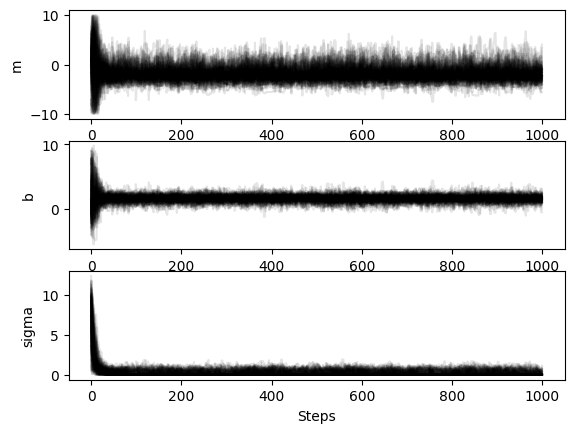

In [9]:
from simple.plot import chainplot

chains = sampler.get_chain()
chainplot(chains, labels=model.keys())
plt.show()

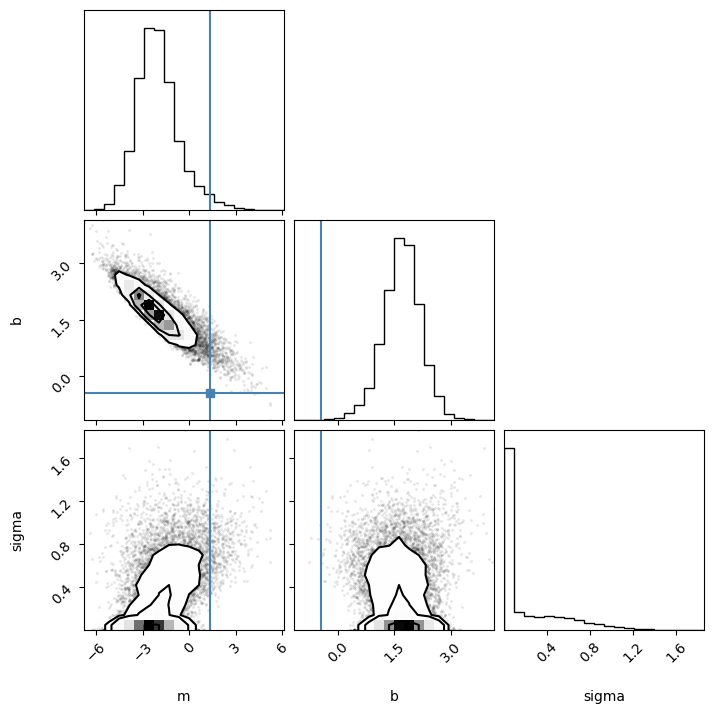

In [10]:
flat_chains = sampler.get_chain(discard=200, flat=True, thin=5)
corner.corner(
    flat_chains,
    labels=model.keys(),
    truths=list(truths.values()),
)
plt.show()

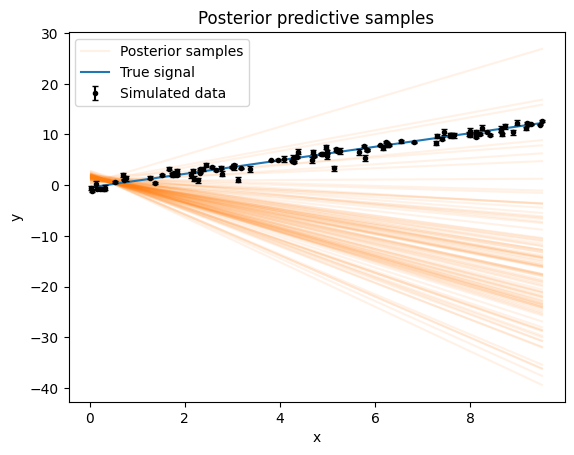

In [11]:
n_pred = 100
rng = np.random.default_rng()
show_idx = rng.choice(flat_chains.shape[0], n_pred, replace=False)
ax = plt.gca()
for i in show_idx:
    ypred = forward_model(dict(zip(model.keys(), flat_chains[i], strict=True)), x)
    ax.plot(
        x,
        ypred,
        "C1-",
        label="Posterior samples" if i == show_idx[0] else None,
        alpha=0.1,
    )
ax.plot(x, y_true, label="True signal")
ax.errorbar(x, y, yerr=yerr, fmt="k.", capsize=2, label="Simulated data")
ax.set_ylabel("y")
ax.set_xlabel("x")
ax.set_title("Posterior predictive samples")
plt.legend()
plt.show()